<img src="https://arbiterz.com/wp-content/uploads/2023/05/Bank_of_England_Logo.png" alt="Me :)" width="300"/>

# Employer Project: Bank of England

# Dream Team

#

<a id="Table_of_contents"></a>
# Table of Contents

### 1. Data ingestion and Initial Inspection

1.1 **[Introduction](#Introduction)**
   
1.2 **[Key information from the Metadata](#Key_information_from_the_Metadata)** \
   I. Original and Final Data after Analysis

1.3 **[Setting up the Notebook workflow](#Setting-up-the-Notebook-workflow)** \
    I. Imports\
    II. Configuration settings and constants \
    III. Functions to load and save data

1.4 **[Sense Checking the DataFrames](#Sense_Checking_the_DataFrames)**


### 2. Predictive Modeling: Random Forest

2.0 **[Data Preparation](#Data_Preparation)**  

2.1 **[Random Forest](#Random_Forest)** \
      I. Correlation matrix and VIF \
      II. Random Forest Model Fit and Feature Importances 


### 3. Predictive Modeling: SARIMA Model

3.1 **[Sesonal AutoRegressive Integrated Moving Average (SARIMA) Model](#Sesonal_AutoRegressive_Integrated_Moving_Average_(SARIMA)_Model)** \
      I. Data preparation \
      II. SARIMA Model Fit \
      III. Residual diagnostics and Statistical test \
      IV. Forecast and Visualisations


> **Objective:**
  > Predictive model for forecasting the tone of upcoming Bank of England speeches based on past economic indicators.

#

# 1. Data ingestion and Initial Inspection

<a id="Introduction"></a>
## 1.1 Introduction

This notebook is the third of a project of four. It explores predictive modeling to analyse the relationship between sentiment scores and economic indicators.  

**1. Random Forest Model**  
The Random Forest model identifies feature importance for predicting sentiment scores. Despite thorough preprocessing with correlation matrices and VIF to address multicollinearity, the model struggles to achieve meaningful accuracy to sentiment predictions.  

**2. SARIMA Model**  
The SARIMA model forecasts sentiment trends over time. While it effectively captures overall trends, its precision is limited, residual diagnostics confirm the model's statistical validity but highlight its inability to explain short-term variations.

##

<a id="Key_information_from_the_Metadata"></a>
## 1.2 Key information from the metadata:

<a id="Introduction"></a>
## 1.1 Introduction

### I. Original and Final Data after Analysis

The *BoE_3* notebook utilizes two datasets originated in *BoE_2*:  

1. **merged_df.csv**: Used for Random Forest modeling to analyse feature importance in predicting sentiment scores.  
2. **lagged_df.csv**: A version of *merged_df* with added lag and 3-month average variables, designed for deeper investigation within the SARIMA model.  

These datasets enable predictive modeling, focusing on feature importance and time series forecas. No oter files has been originated.

# 

<a id="Setting-up-the-Notebook-workflow"></a>
## 1.3 Setting up the Notebook workflow

### I. Imports

In [1]:
# Data Manipulation and Analysis
import pandas as pd  
import numpy as np
import pmdarima as pm
import re

# Utility and System Management
import os 
import sys 
import subprocess 
import logging  
from datetime import datetime 

# Statistical Modeling and Analysis
import math
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from statsmodels.formula.api import ols 
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tsa.stattools import adfuller  
from scipy import stats 
from scipy.spatial.distance import cdist  
from scipy.stats import shapiro, norm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Visualization
import matplotlib.pyplot as plt  
import matplotlib.cm as cm 
import seaborn as sns  
from wordcloud import WordCloud
from IPython.display import display, Markdown, HTML
from matplotlib.backends.backend_pdf import PdfPages

# Machine Learning (ML) Algorithms and Evaluation
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.ensemble import RandomForestRegressor  
from sklearn.cluster import KMeans 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, 
    accuracy_score, confusion_matrix, classification_report, silhouette_score)
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve)
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Natural Language Processing (NLP)
import nltk  
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, pipeline)
from transformers import BertTokenizer, BertForSequenceClassification 
import spacy

# Warnings and Settings
import warnings  #
warnings.filterwarnings("ignore") 
plt.rcParams['figure.figsize'] = [15, 10]  


###

### II. Configuration settings and constants

In [4]:
# To print your directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: C:\Users\user\Desktop\BoE\Data\core_data_sets


In [5]:
# Configuration settings and constants

# Suppress FutureWarning
warnings.filterwarnings("ignore")

# Suppress informational messages
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# Insert your own directory where data files are stored. Use \\
# sign to separate in the path. 
DATA_PATH = (r'C:\Users\user\Desktop\BoE\Data\core_data_sets')  
# Directory path where output files will be saved
OUTPUT_PATH = DATA_PATH
# Ensure the directories exist
LOG_FILE = os.path.join(OUTPUT_PATH, 'analysis.log')  # Log file path

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Set up logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s', handlers=[
    logging.FileHandler(LOG_FILE),
    logging.StreamHandler()
])

# Version information
__version__ = "1.0.0"

# Print version
print(f"Current version: {__version__}")

print("Configuration settings:")
print(f"DATA_PATH: {DATA_PATH}")
print(f"OUTPUT_PATH: {OUTPUT_PATH}")
print(f"Output path exists: {os.path.exists(OUTPUT_PATH)}")
print(f"Output path is writable: {os.access(OUTPUT_PATH, os.W_OK)}")
print(f"LOG_FILE: {LOG_FILE}")

Current version: 1.0.0
Configuration settings:
DATA_PATH: C:\Users\user\Desktop\BoE\Data\core_data_sets
OUTPUT_PATH: C:\Users\user\Desktop\BoE\Data\core_data_sets
Output path exists: True
Output path is writable: True
LOG_FILE: C:\Users\user\Desktop\BoE\Data\core_data_sets\analysis.log


###

### III. Functions to load and save data

In [9]:
def load_multiple_files(file_paths):
    dataframes = {}
    
    for file_path in file_paths:
        try:
            file_name = file_path.split('/')[-1].split('.')[0]
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
            elif file_path.endswith('.xlsx') or file_path.endswith('.xls'):
                df = pd.read_excel(file_path)
            else:
                logging.warning(f"Unsupported file format: {file_path}")
                continue

            dataframes[file_name] = df
            logging.info(f"Data loaded successfully from {file_path}")
        except Exception as e:
            logging.error(f"Error loading data from {file_path}: {str(e)}")

    return dataframes


In [11]:
# Apply the function
file_list = ['merged_df.csv', 'lagged_df.csv']
dataframes_dict = load_multiple_files(file_list)

2024-11-18 14:22:03,618 - INFO - Data loaded successfully from merged_df.csv
2024-11-18 14:22:03,634 - INFO - Data loaded successfully from lagged_df.csv


In [239]:
# Function to save results
def save_results(df, file_path):
    if df is None:
        logging.error(f"Cannot save results to {file_path}: DataFrame is None")
        return
    try:
        logging.info(f'Saving results to {file_path}')
        df.to_csv(file_path, index=False)
        logging.info(f'Successfully saved results to {file_path}')
    except Exception as e:
        logging.error(f"Error saving file to {file_path}: {str(e)}")
        raise
        
# Optional, to save it to pickle for faster file handling
# def save_to_pickle(df, file_path):
    #logging.info(f'Saving DataFrame to {file_path}')
    #df.to_pickle(file_path)

# def load_from_pickle(file_path):
    #logging.info(f'Loading DataFrame from {file_path}')
    #return pd.read_pickle(file_path)

# Utility function to save plots
def save_plot(filename):
    plt.savefig(filename, bbox_inches='tight')
    print(f"Plot saved to {filename}")

In [241]:
def save_plots_to_pdf(plot_functions, pdf_path=None):
    """
    Generates and saves multiple plots to a single PDF file if a path is provided.
    """
    if pdf_path:
        with PdfPages(pdf_path) as pdf:
            for plot_func in plot_functions:
                # Clear any existing figures
                plt.close('all') 
                # Call the plotting function to create the plots
                plot_func()
                # Save all open figures to the PDF
                for figure in [plt.figure(i) for i in plt.get_fignums()]:
                    pdf.savefig(figure)
                # Close all figures after saving
                plt.close('all')
        print(f"Plots saved to {pdf_path}")
    else:
        # Display the plots if no path is specified
        for plot_func in plot_functions:
            plot_func()

# Using the save_plots_to_pdf function
# plot_functions = [plot1, plot2]
# save_plots_to_pdf(plot_functions, pdf_path="output_plots.pdf")

In [13]:
# Load the dataset
merged_df = pd.read_csv('merged_df.csv')
lagged_df = pd.read_csv('lagged_df.csv')

##

<a id="Sense_Checking_the_DataFrames"></a>
# 1.4 Sense Checking Raw Data

In [247]:
def process_dataframe(df, show_description=True):
    """
    Function to inspect and process the DataFrame.
    
    Steps:
    1. View the DataFrame (first 5 rows).
    2. Show the shape of the DataFrame.
    3. Check for missing values.
    4. Display metadata information.
    5. Show descriptive statistics for numerical columns-.
    """
    # View the first 5 rows of the DataFrame
    print('\033[1mFirst 5 rows of the DataFrame:\033[0m')
    print(df.head())

    # Investigate the shape of the DataFrame
    print('\n\033[1mShape of the DataFrame:\033[0m', df.shape)
    
    # Check for missing values in each column
    print('\n\033[1mMissing values for each column:\033[0m')
    print(df.isna().sum())
    
    # Show metadata of the DataFrame
    print('\n\033[1mDataFrame info:\033[0m')
    df.info()

    # Show the column names
    print('\n\033[1mColumn Names:\033[0m')
    print(df.columns.tolist())

    # Show descriptive statistics for numerical columns
    if show_description:
        print('\n\033[1mDescriptive statistics of the numerical data:\033[0m')
        print(df.describe().round(2))

    return df

In [249]:
# Call the function for the DataFrames

# List of DataFrames to process
df_list = [merged_df, lagged_df]
df_names = ['merged_df', 'lagged_df']

# Process each DataFrame
for df, name in zip(df_list, df_names):
    print(f"\nProcessing DataFrame: {name}")
    process_dataframe(df, show_description=True)


Processing DataFrame: merged_df
First 5 rows of the DataFrame:
      reference        date  author  year  text_length finbert_sentiment  \
0  r030120a_BOE  2003-01-20  george  2003        11757           Neutral   
1  r030129a_BOE  2003-01-29    bean  2003        30848           Neutral   
2  r030218a_BOE  2003-02-18  barker  2003        40668          Negative   
3  r030313a_BOE  2003-03-13   large  2003        14338           Neutral   
4  r030324a_BOE  2003-03-24  george  2003        10622           Neutral   

   finbert_score  gdp_rate  cpi_rate  unemployment_rate  \
0       0.996209  0.004033  0.003587           5.127928   
1       0.971784  0.004033  0.003587           5.127928   
2       0.754248 -0.002150  0.003547           5.166501   
3       0.994006 -0.002150  0.003547           5.166501   
4       0.993341  0.009420  0.003282           5.116309   

   unemployment_rate_change  weekly_earning_rate  redundancies  bank_rate  \
0                  0.023931             0.00417

**[Table of Contents](#Table_of_contents)**

#

# 2. Predictive Modeling: Random Forest

<a id="Data_Preparation"></a>
## 2.0 Data Preparation

- *merged_df*

In [256]:
# Ensure 'date' is in datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Drop unecessary columns
merged_df = merged_df.drop(['text_length', 'unemployment_rate_change', 'reference'], axis=1)

merged_df.head()

,date,author,year,finbert_sentiment,finbert_score,gdp_rate,cpi_rate,unemployment_rate,weekly_earning_rate,redundancies,bank_rate,gilt_purchases_bn,bond_purchases,asset_purchase_decisions
0,2003-01-20,george,2003,Neutral,0.996209,0.004033,0.003587,5.127928,0.004170,185204.0,0.0400,0.0,0.0,0.0
1,2003-01-29,bean,2003,Neutral,0.971784,0.004033,0.003587,5.127928,0.004170,185204.0,0.0400,0.0,0.0,0.0
2,2003-02-18,barker,2003,Negative,0.754248,-0.002150,0.003547,5.166501,0.013887,179137.0,0.0375,0.0,0.0,0.0
3,2003-03-13,large,2003,Neutral,0.994006,-0.002150,0.003547,5.166501,0.013887,179137.0,0.0375,0.0,0.0,0.0
4,2003-03-24,george,2003,Neutral,0.993341,0.009420,0.003282,5.116309,-0.002546,176542.0,0.0375,0.0,0.0,0.0


- *lagged_df*

In [259]:
# Ensure 'date' is in datetime format
lagged_df['date'] = pd.to_datetime(lagged_df['date'], errors='coerce')

# Drop unecessary columns
lagged_df = lagged_df.drop(('reference'), axis=1)

lagged_df.head()

,date,author,year,finbert_sentiment,finbert_score,gdp_rate,cpi_rate,unemployment_rate,weekly_earning_rate,redundancies,...,bank_rate_lag_3,bank_rate_lag_6,bank_rate_lag_9,weekly_earning_rate_lag_3,weekly_earning_rate_lag_6,weekly_earning_rate_lag_9,gdp_rate_3_month_avg,cpi_rate_3_month_avg,bank_rate_3_month_avg,weekly_earning_rate_3_month_avg
0,2003-06-12,large,2003,Neutral,0.913007,0.005819,-0.001589,4.939741,0.002969,155985.0,...,0.0375,0.0375,0.0400,-0.002546,0.013887,0.004170,0.007019,0.000035,0.037500,0.001130
1,2003-06-18,george,2003,Neutral,0.992598,0.003841,-0.000822,5.064130,0.003312,145499.0,...,0.0375,0.0375,0.0400,-0.002546,-0.002546,0.004170,0.005160,-0.001333,0.037500,0.003083
2,2003-07-21,nickell,2003,Neutral,0.809586,0.000610,0.003676,5.057789,0.001521,155213.0,...,0.0375,0.0375,0.0375,0.002969,-0.002546,0.013887,0.003423,0.000422,0.036667,0.002600
3,2003-08-19,bean,2003,Neutral,0.898124,0.005873,0.003108,5.048588,0.004555,154724.0,...,0.0375,0.0375,0.0375,0.002969,-0.002546,0.013887,0.003441,0.001987,0.035833,0.003129
4,2003-08-28,tucker,2003,Neutral,0.892041,0.005873,0.003108,5.048588,0.004555,154724.0,...,0.0375,0.0375,0.0375,0.003312,-0.002546,-0.002546,0.004118,0.003297,0.035000,0.003544


- *Visualisations*

In [262]:
def vis_check_data(df, file_name):
    try:
        # Data Shape
        print(f"Sense checking data for {file_name}")
        
        print(f"\n{file_name} - Data Shape: {df.shape}")
        
        # Plot histograms for numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if numerical_cols:
            print("\nPlotting histograms for numerical columns...")
            df[numerical_cols].hist(figsize=(10, 10))
            plt.suptitle(f'Histograms for {file_name} - Numerical Columns')
            plt.show()

        # Plot count plots for non-numerical (categorical) columns
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        if categorical_cols:
            print("\nPlotting count plots for categorical columns...")
            for col in categorical_cols:
                # Get top 10 and bottom 10 unique values
                value_counts = df[col].value_counts()
                if len(value_counts) > 20:
                    top_10 = value_counts.nlargest(10)
                    bottom_10 = value_counts.nsmallest(10).sort_values(ascending=False)
                    value_counts = pd.concat([top_10, bottom_10])

                plt.figure(figsize=(10, 6))
                sns.countplot(y=df[col], order=value_counts.index)
                plt.title(f'Count Plot of {col} in {file_name}')
                plt.xlabel('Count')
                plt.ylabel(col)
                
                # Add subtitle below the title
                plt.text(0.5, -0.15, 'Note: For larger sets, the top and bottom 10 are displayed',
                         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, style='italic')

                plt.tight_layout()
                plt.show()

        # Plot all columns (just for a general view)
        print("\nPlotting all columns in the dataset...")
        df.plot(figsize=(10, 6))
        plt.title(f'Plot of all columns in {file_name}')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during sense check for {file_name}: {str(e)}")

Sense checking data for merged_df

merged_df - Data Shape: (1058, 14)

Plotting histograms for numerical columns...


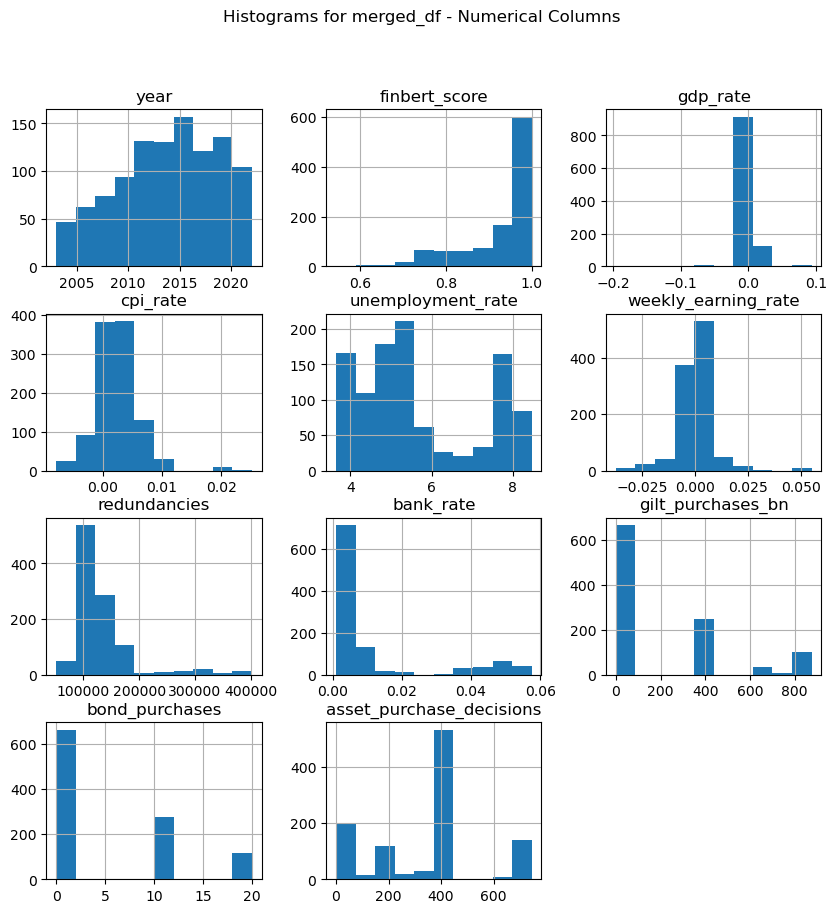


Plotting count plots for categorical columns...


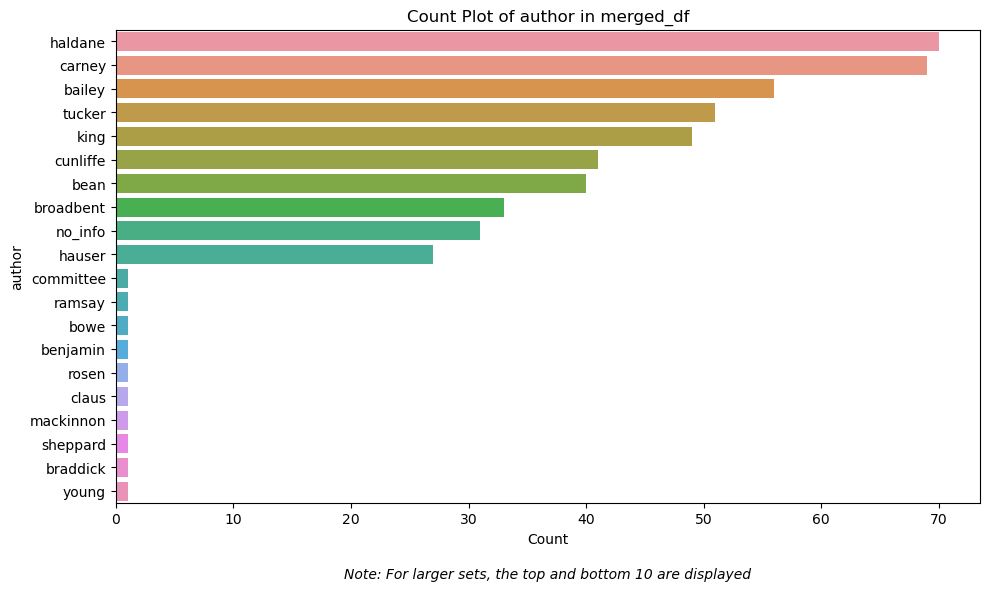

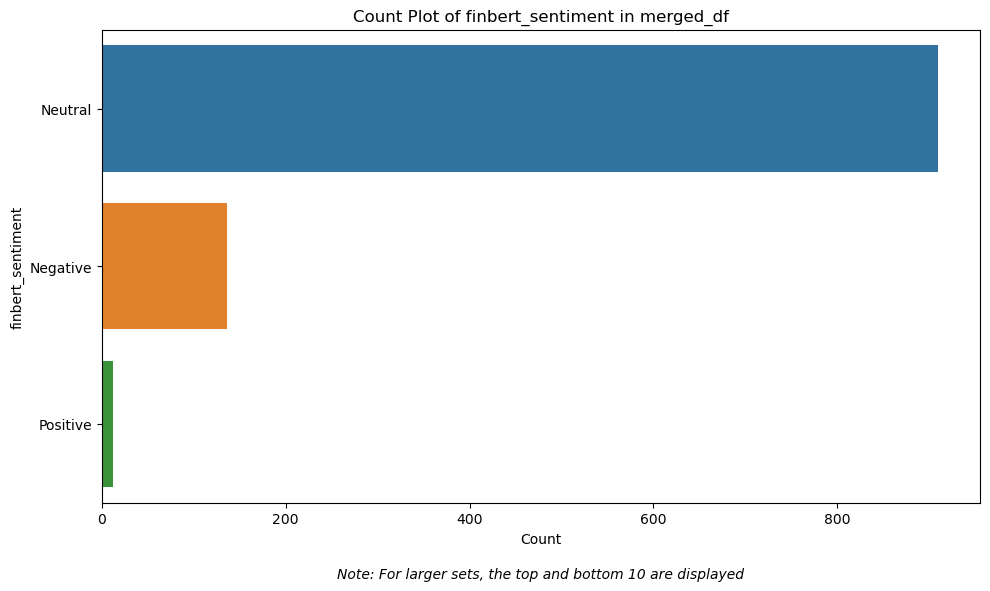


Plotting all columns in the dataset...


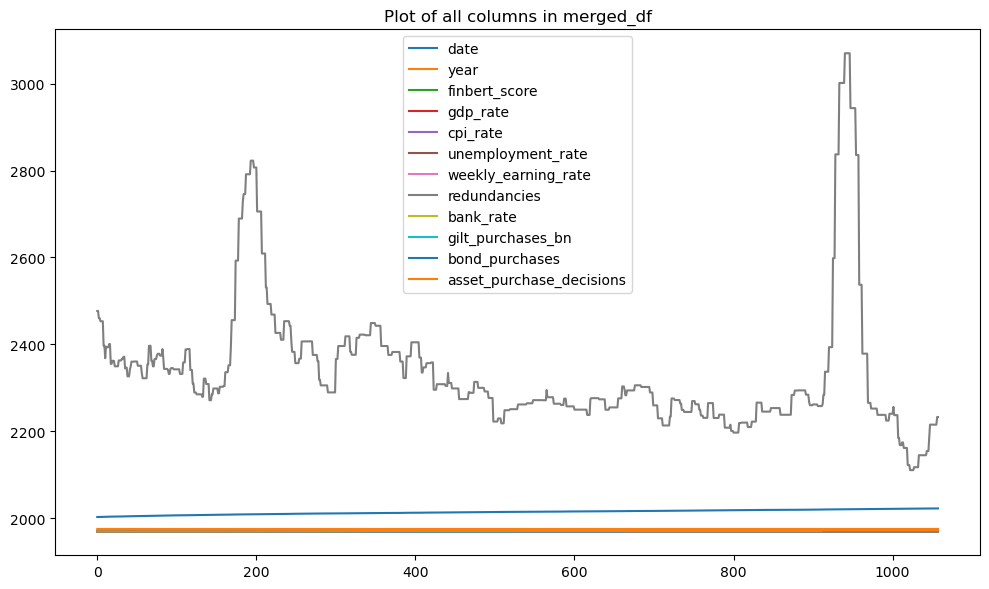

Sense checking data for lagged_df

lagged_df - Data Shape: (1049, 30)

Plotting histograms for numerical columns...


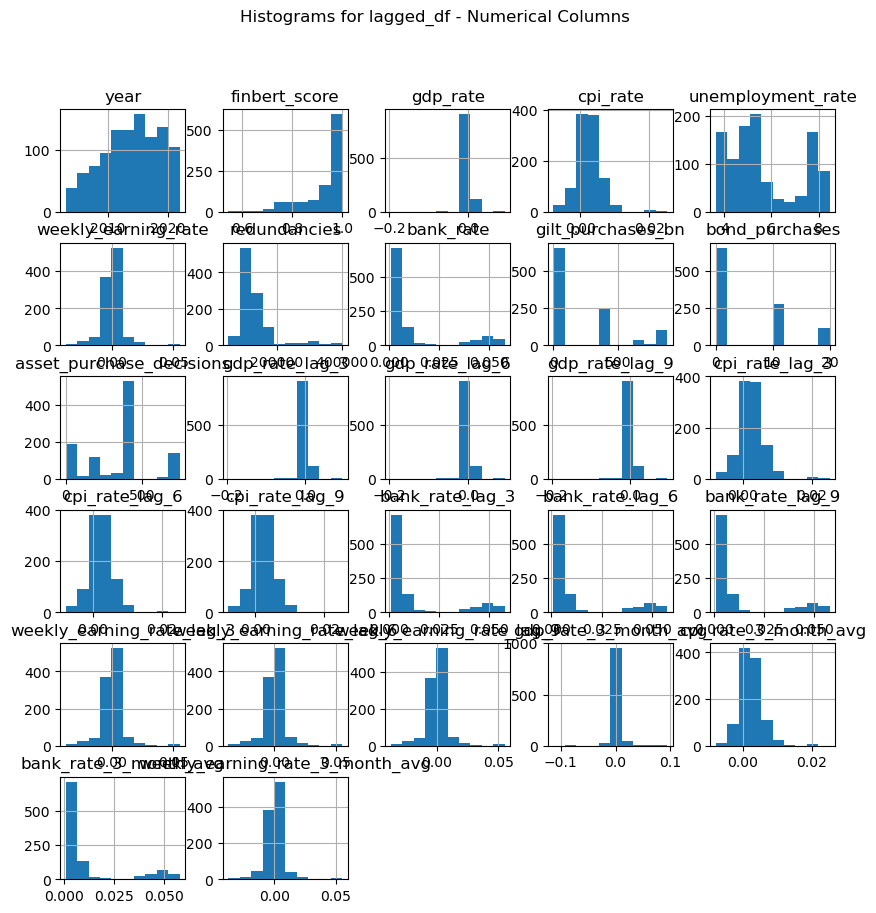


Plotting count plots for categorical columns...


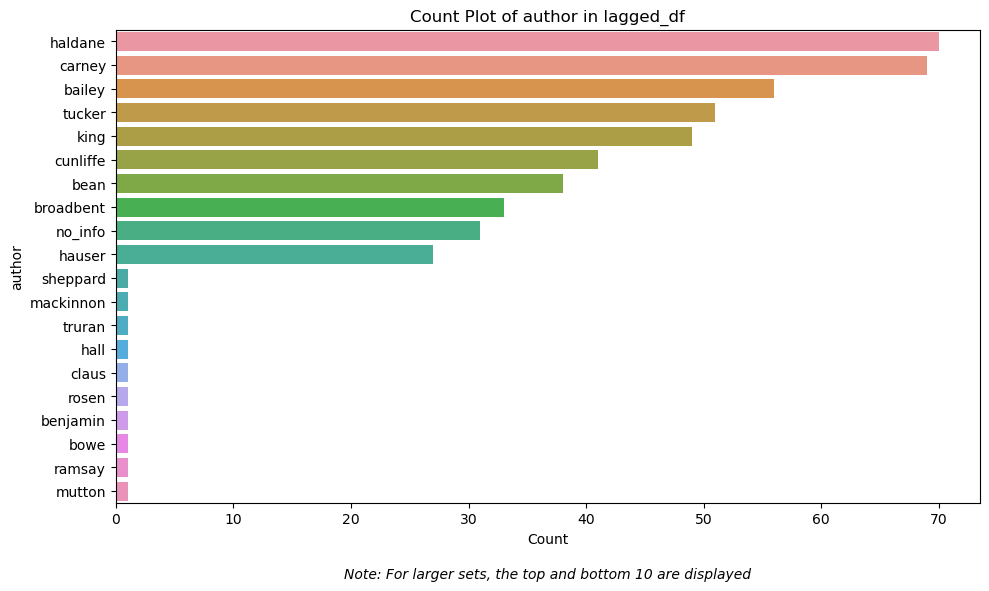

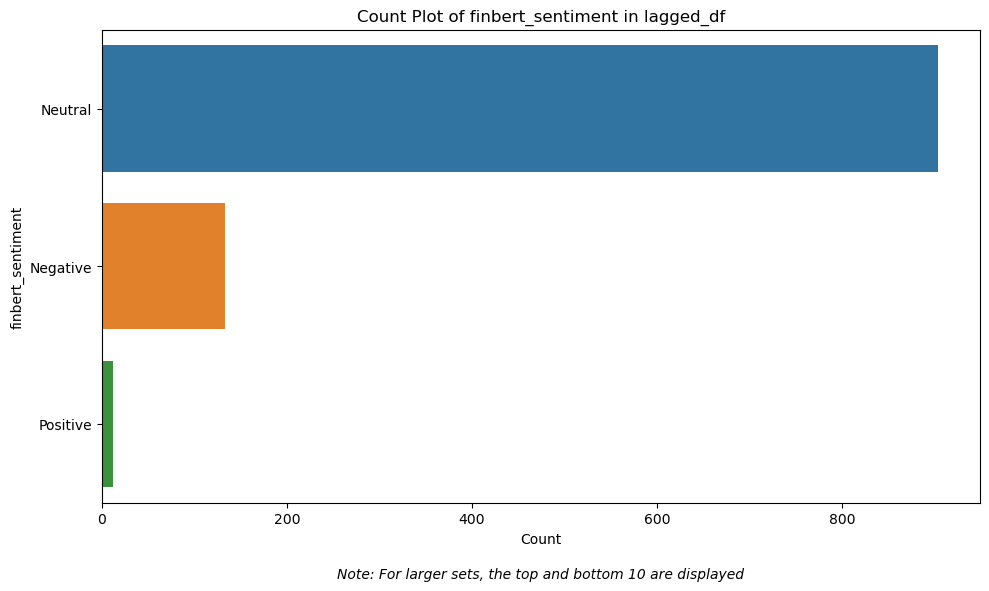


Plotting all columns in the dataset...


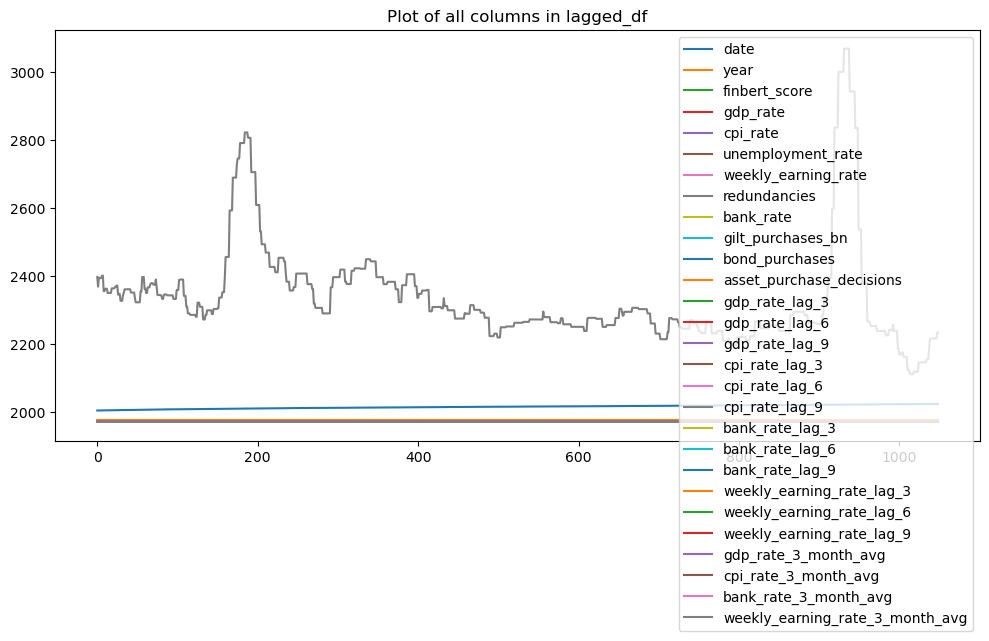

In [264]:
vis_check_data(merged_df, 'merged_df')
vis_check_data(lagged_df, 'lagged_df')

Sense checking data for merged_df

merged_df - Data Shape: (1058, 14)

Plotting histograms for numerical columns...


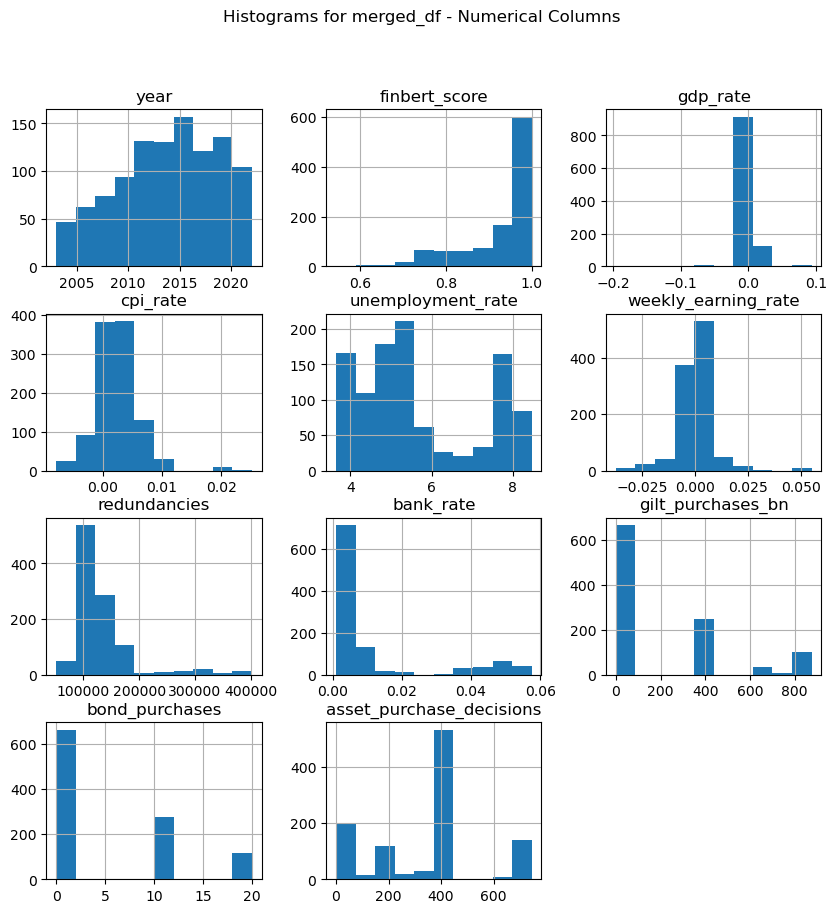


Plotting count plots for categorical columns...


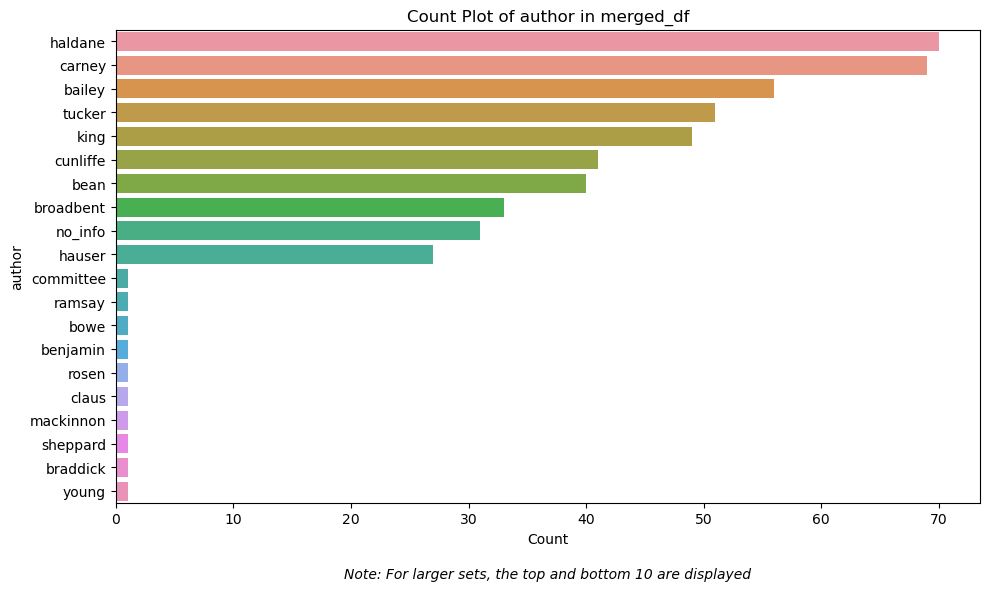

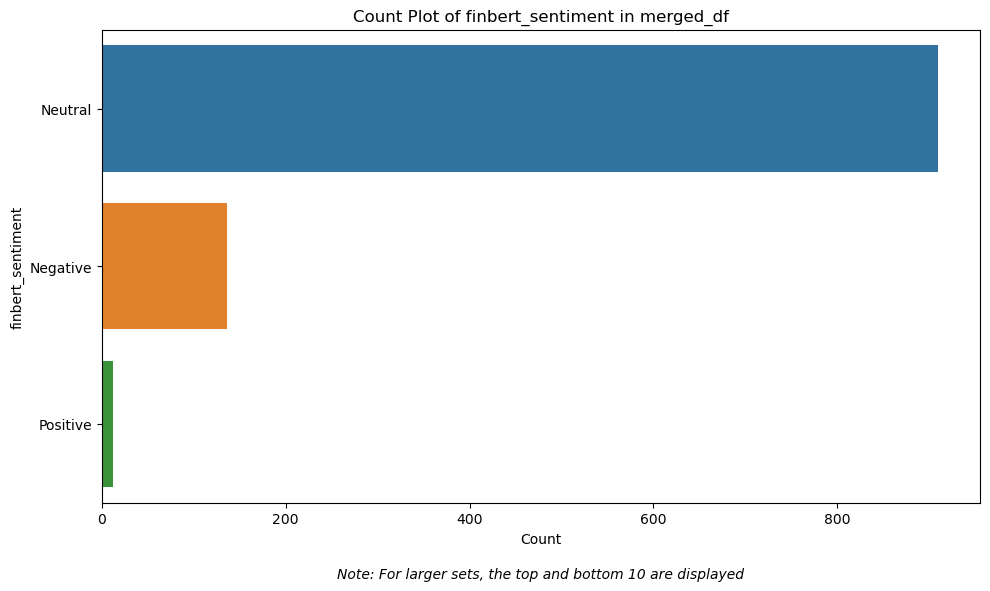


Plotting all columns in the dataset...


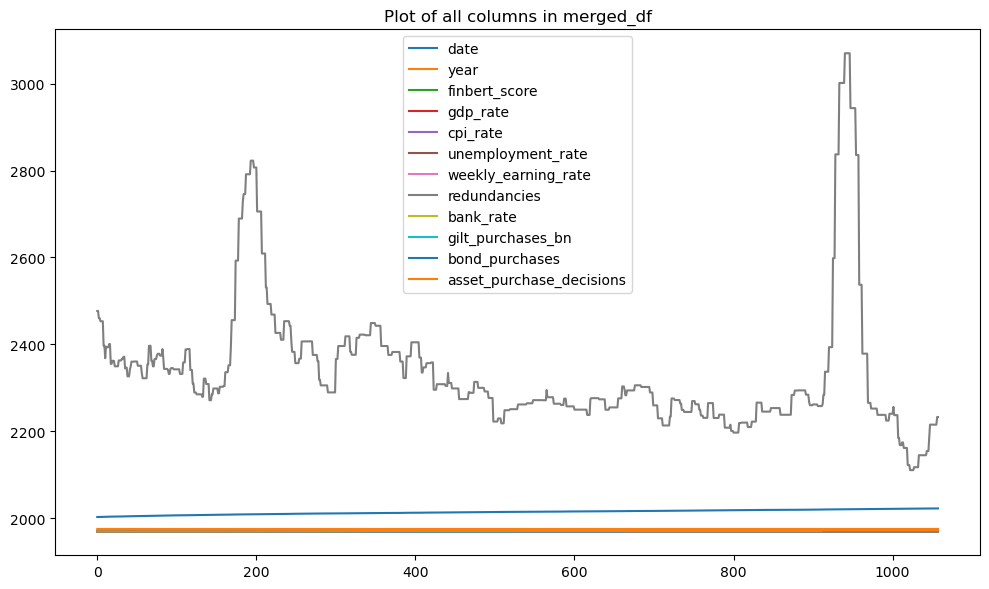

Sense checking data for lagged_df

lagged_df - Data Shape: (1049, 30)

Plotting histograms for numerical columns...


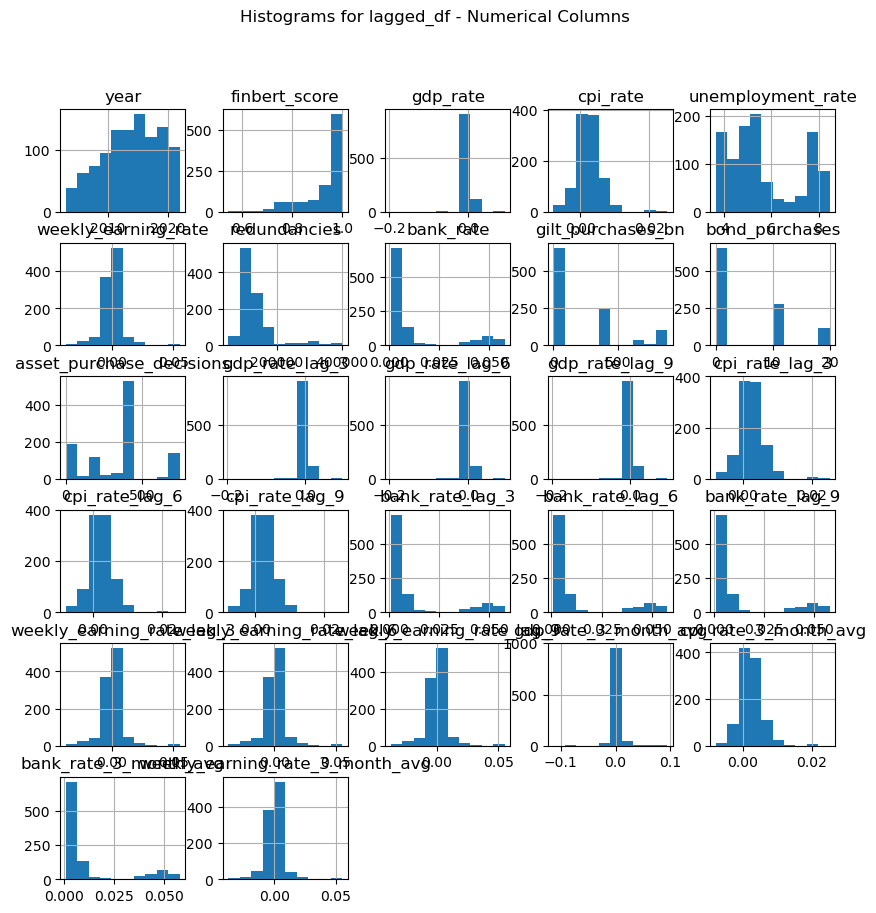


Plotting count plots for categorical columns...


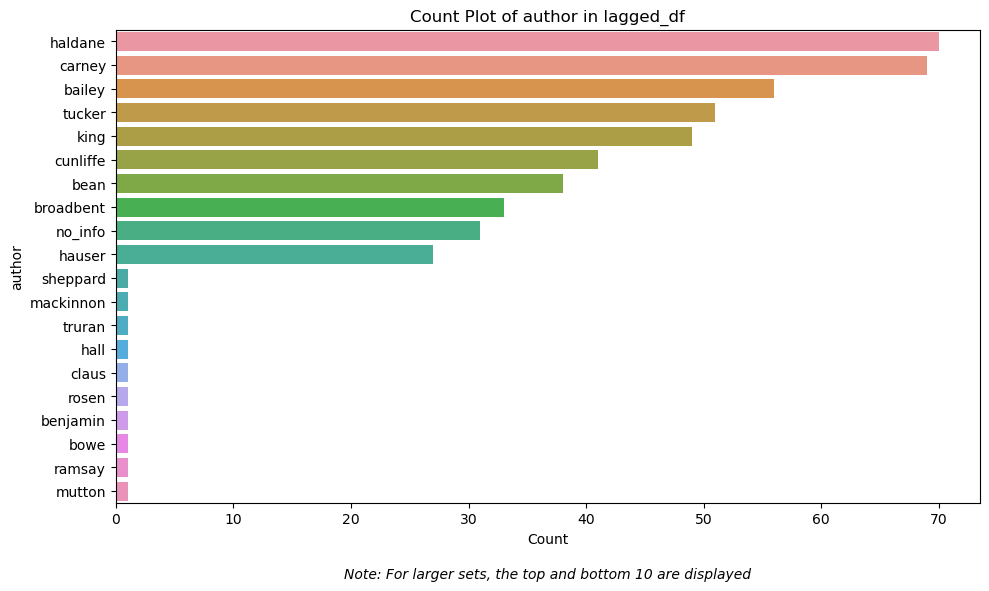

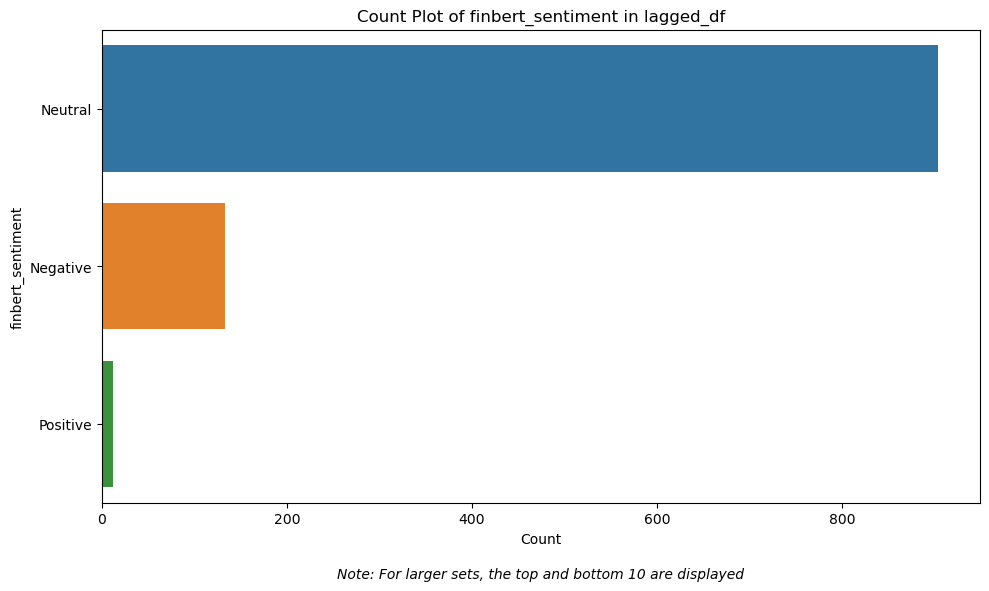


Plotting all columns in the dataset...


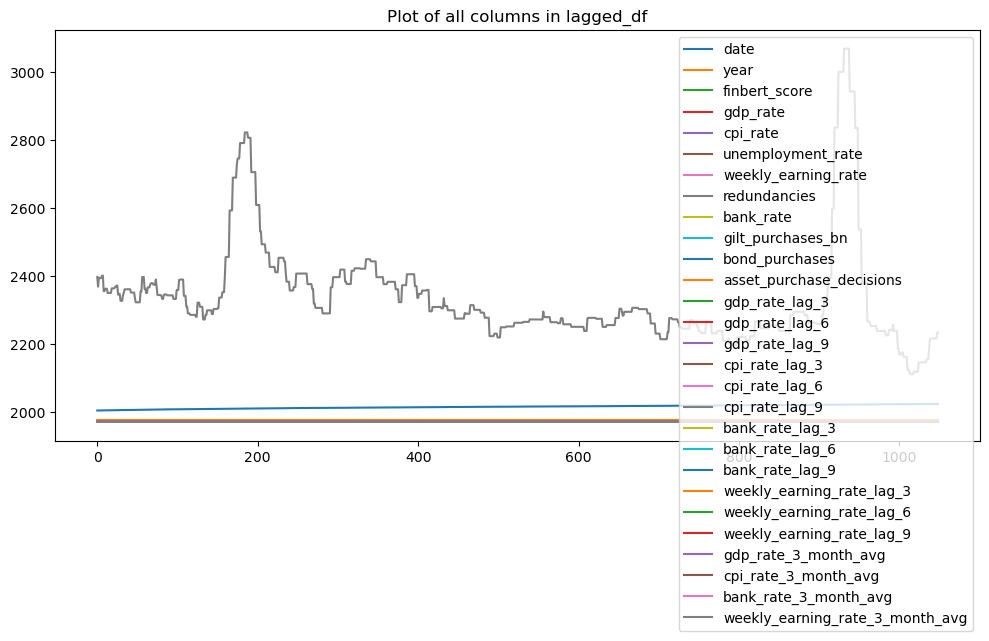

Plots saved to merged_lag_dfs_visualisations.pdf


In [265]:
# Create a PDF.
# Define a list of plotting functions with their arguments
plot_functions = [
    lambda: vis_check_data(merged_df, 'merged_df'),
    lambda: vis_check_data(lagged_df, 'lagged_df')
]

# Save plots to a single PDF
save_plots_to_pdf(plot_functions, pdf_path="merged_lag_dfs_visualisations.pdf")

##

<a id="Random_Forest"></a>
## 2.1 Random Forest

###  I. Analyse correlation matrix and VIF

In [270]:
# Select columns for correlation analysis
# This includes 'finbert_score' for sentiment and the economic indicators

# 1st attempt
# correlation_columns = ['finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 'redundancies', 
#                     'bank_rate', 'gilt_purchases_bn', 'bond_purchases', 'asset_purchase_decisions']

correlation_columns = ['finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 'redundancies', 
                     'bank_rate', 'asset_purchase_decisions']


# Calculate the correlation matrix
correlation_matrix = merged_df[correlation_columns].corr()

print("Correlation Matrix")
print(correlation_matrix)


Correlation Matrix
                          finbert_score  gdp_rate  cpi_rate  \
finbert_score                  1.000000  0.002132 -0.002179   
gdp_rate                       0.002132  1.000000  0.090232   
cpi_rate                      -0.002179  0.090232  1.000000   
unemployment_rate             -0.004944 -0.040273 -0.065202   
weekly_earning_rate           -0.013869  0.056161 -0.159247   
redundancies                  -0.052683 -0.023587 -0.154973   
bank_rate                      0.001256 -0.065187  0.007280   
asset_purchase_decisions      -0.012466  0.176821  0.199649   

                          unemployment_rate  weekly_earning_rate  \
finbert_score                     -0.004944            -0.013869   
gdp_rate                          -0.040273             0.056161   
cpi_rate                          -0.065202            -0.159247   
unemployment_rate                  1.000000            -0.036854   
weekly_earning_rate               -0.036854             1.000000   
redun

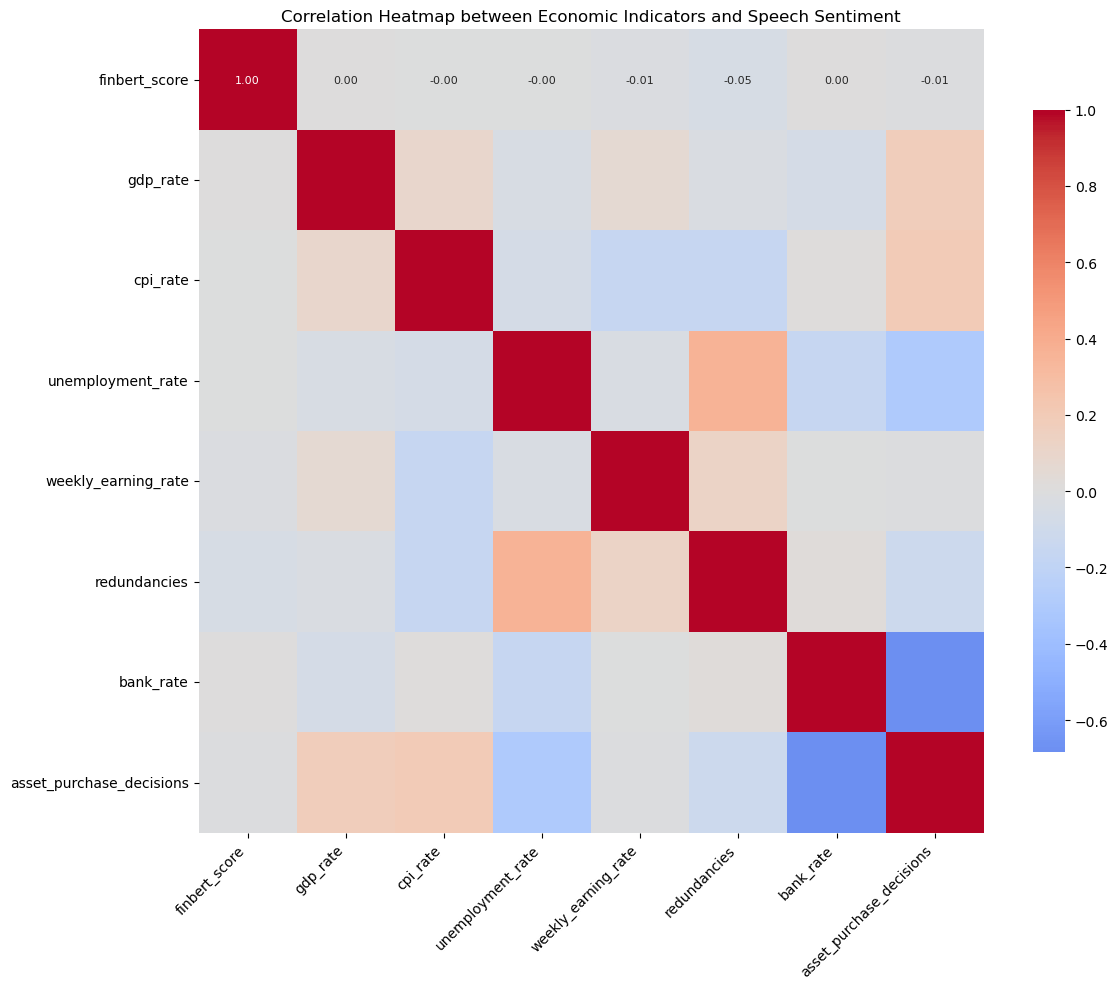

In [271]:
# Visualize the correlation matrix with a heatmap

# Set up the heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            cbar_kws={"shrink": .8}, annot_kws={"size": 8})

plt.title("Correlation Heatmap between Economic Indicators and Speech Sentiment")
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

In [275]:
# Function for checking the Variance inflation factor.
def calculate_vif(df, x_cols):
    X = df[x_cols]
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# x_columns multicollinearity
x_columns = ['gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 'redundancies',
             'bank_rate', 'asset_purchase_decisions']


# Calculate VIF
print(f"Checking for Variance Inflation Factors for multicollinearity")
print(calculate_vif(merged_df, x_columns))

Checking for Variance Inflation Factors for multicollinearity
                    Feature        VIF
0                     const  57.681014
1                  gdp_rate   1.049719
2                  cpi_rate   1.159147
3         unemployment_rate   1.800846
4       weekly_earning_rate   1.050452
5              redundancies   1.226881
6                 bank_rate   2.835100
7  asset_purchase_decisions   3.187118


###

### II. Random Forest Model Fit and Feature Importances 

In [279]:
def random_forest_model(df, target_column, feature_columns=None, test_size=0.3, random_state=42, n_estimators=100, max_depth=None):
    # If feature_columns is None, use all columns except the target column
    if feature_columns is None:
        X = df.drop(columns=[target_column])
    else:
        X = df[feature_columns]

    # Define the target variable
    y = df[target_column]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Instantiate the RandomForestRegressor
    rf = RandomForestRegressor(random_state=random_state, n_estimators=n_estimators, max_depth=max_depth)

    # Fit the model
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Evaluate the model performance (MSE, MAE, RMSE)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    R2 = r2_score(y_test, y_pred)

    # Print performance metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {R2}")

    # Show feature importances
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title("Feature Importances in Random Forest Model")
    plt.show()

    # Return the model and data used for cross-validation
    return rf, X, y


Mean Squared Error (MSE): 0.008154749558446668
Mean Absolute Error (MAE): 0.06998986996240818
Root Mean Squared Error (RMSE): 0.09030365196627803
R-squared: -0.036416160610512005

Feature Importances:
cpi_rate                    0.214098
gdp_rate                    0.211454
unemployment_rate           0.191818
redundancies                0.180125
weekly_earning_rate         0.130462
bank_rate                   0.042318
asset_purchase_decisions    0.029725
dtype: float64


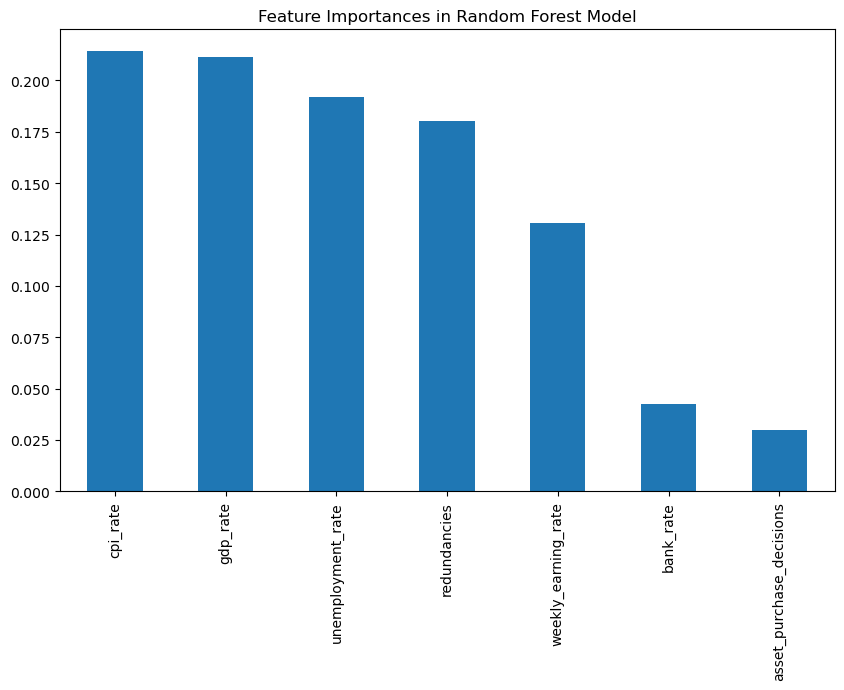

In [281]:
# Use the function with different feature sets
# Set 1: Key Economic Indicators with Recent Lags

rf_model, X, y = random_forest_model(
    df=merged_df, 
    target_column='finbert_score', 
    feature_columns=['gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 
                     'redundancies', 'bank_rate', 'asset_purchase_decisions'], 
    max_depth=4
)


Mean Squared Error (MSE): 0.00845496864345584
Mean Absolute Error (MAE): 0.07088539637406482
Root Mean Squared Error (RMSE): 0.09195090344012852
R-squared: -0.07457207321053971

Feature Importances:
gdp_rate               0.228575
cpi_rate               0.226375
unemployment_rate      0.203401
redundancies           0.181393
weekly_earning_rate    0.160255
dtype: float64


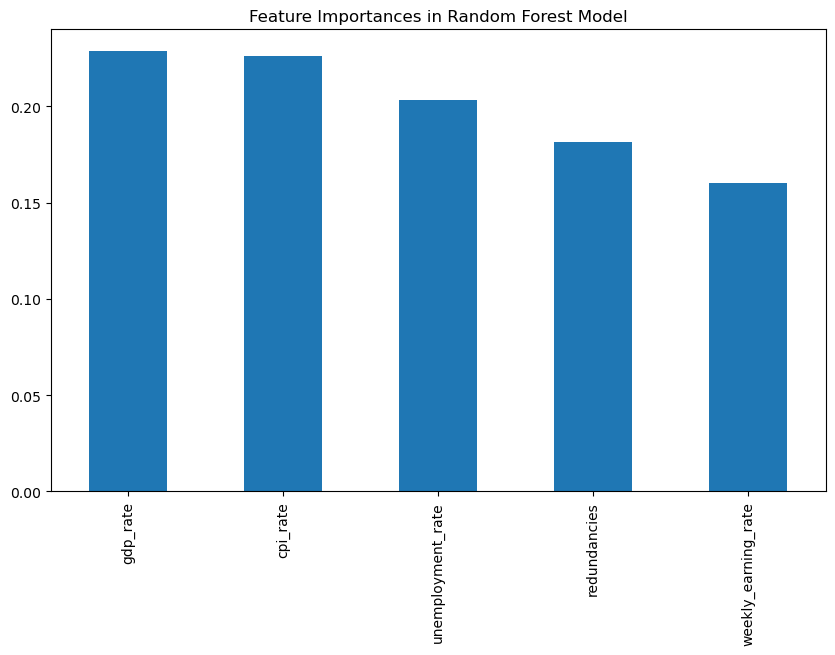

(RandomForestRegressor(max_depth=6, random_state=42),
       gdp_rate  cpi_rate  unemployment_rate  weekly_earning_rate  redundancies
 0     0.004033  0.003587           5.127928             0.004170      185204.0
 1     0.004033  0.003587           5.127928             0.004170      185204.0
 2    -0.002150  0.003547           5.166501             0.013887      179137.0
 3    -0.002150  0.003547           5.166501             0.013887      179137.0
 4     0.009420  0.003282           5.116309            -0.002546      176542.0
 ...        ...       ...                ...                  ...           ...
 1053  0.009194  0.019675           3.856797            -0.000519       89676.0
 1054  0.009194  0.019675           3.856797            -0.000519       89676.0
 1055  0.009194  0.019675           3.856797            -0.000519       89676.0
 1056 -0.000315  0.003922           3.803156             0.000756       96095.0
 1057 -0.000315  0.003922           3.803156             0.000756 

In [283]:
# Set 2: Key Economic Indicators with 3-Month Averages
random_forest_model(
    merged_df, 
    target_column='finbert_score', 
    feature_columns=['gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 'redundancies'], 
    max_depth=6
)


In [285]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.mean(np.sqrt(-cv_scores))
print(f"Cross-validated RMSE: {cv_rmse}")



Cross-validated RMSE: 0.08793555213322668


**Comment on OLS an Random Forest Results:**

Both models fail to capture a significant relationship between the predictors and the finbert_score. The OLS model suffers from poor fit and insignificant predictors, while the Random Forest model's performance (negative R-squared) indicates overfitting or a lack of meaningful signal in the features. This could imply that the selected predictors are insufficient for modeling finbert_score or that the relationship is non-linear or complex, requiring alternative approaches or additional data preprocessing.


**[Table of Contents](#Table_of_contents)**

#

# 3. Predictive Modeling: SARIMA Model

<a id="Sesonal_AutoRegressive_Integrated_Moving_Average_(SARIMA)_Model"></a>
## 3.1 Sesonal AutoRegressive Integrated Moving Average (SARIMA) Model

###  I. Data Preparation

- *Correlation Matrix*

In [294]:
# Apply log transformation to finbert_score
lagged_df['log_finbert_score'] = np.log(lagged_df['finbert_score'] + 1) 

print(lagged_df.columns)

Index(['date', 'author', 'year', 'finbert_sentiment', 'finbert_score',
       'gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate',
       'redundancies', 'bank_rate', 'gilt_purchases_bn', 'bond_purchases',
       'asset_purchase_decisions', 'gdp_rate_lag_3', 'gdp_rate_lag_6',
       'gdp_rate_lag_9', 'cpi_rate_lag_3', 'cpi_rate_lag_6', 'cpi_rate_lag_9',
       'bank_rate_lag_3', 'bank_rate_lag_6', 'bank_rate_lag_9',
       'weekly_earning_rate_lag_3', 'weekly_earning_rate_lag_6',
       'weekly_earning_rate_lag_9', 'gdp_rate_3_month_avg',
       'cpi_rate_3_month_avg', 'bank_rate_3_month_avg',
       'weekly_earning_rate_3_month_avg', 'log_finbert_score'],
      dtype='object')


In [296]:
# Selecting relevant columns for correlation

# 1st attempt (taking all in):
# correlation_cols = ['finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate',
#       'unemployment_rate_change', 'weekly_earning_rate', 'redundancies', 'gilt_purchases_bn', 'bond_purchases',
#       'asset_purchase_decisions', 'gdp_rate_lag_3', 'gdp_rate_lag_6', 'gdp_rate_lag_9', 'cpi_rate_lag_3', 'cpi_rate_lag_6', 'cpi_rate_lag_9',
#       'weekly_earning_rate_lag_3', 'weekly_earning_rate_lag_6', 'weekly_earning_rate_lag_9', 'gdp_rate_3_month_avg',
#       'cpi_rate_3_month_avg', 'weekly_earning_rate_3_month_avg', 'log_finbert_score']

# 2nd attempt: Selecting variables with moderate to high correlations, excluding predictors with very low correlations
correlation_cols = ['finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 'redundancies',
                    'asset_purchase_decisions', 'gdp_rate_lag_3', 'gdp_rate_lag_6', 'gdp_rate_lag_9', 'cpi_rate_lag_3', 'cpi_rate_lag_6',
                    'cpi_rate_lag_9', 'weekly_earning_rate_lag_3', 'weekly_earning_rate_lag_6', 'weekly_earning_rate_lag_9',
                    'gdp_rate_3_month_avg', 'weekly_earning_rate_3_month_avg', 'log_finbert_score']

correlation_matrix = lagged_df[correlation_cols].corr()

# Display the correlation matrix
print("Correlation Matrix")
print(correlation_matrix)

Correlation Matrix
                                 finbert_score  gdp_rate  cpi_rate  \
finbert_score                         1.000000  0.002306 -0.003016   
gdp_rate                              0.002306  1.000000  0.090274   
cpi_rate                             -0.003016  0.090274  1.000000   
unemployment_rate                    -0.005728 -0.039475 -0.065060   
weekly_earning_rate                  -0.012693  0.057719 -0.160299   
redundancies                         -0.052235 -0.025188 -0.156788   
asset_purchase_decisions             -0.015332  0.181905  0.203347   
gdp_rate_lag_3                       -0.037701  0.454439  0.054957   
gdp_rate_lag_6                       -0.025803  0.095727  0.053479   
gdp_rate_lag_9                       -0.040023 -0.127234  0.005291   
cpi_rate_lag_3                       -0.025886  0.025972  0.525581   
cpi_rate_lag_6                       -0.003932 -0.011319  0.356279   
cpi_rate_lag_9                        0.029791 -0.017347  0.249884   
w

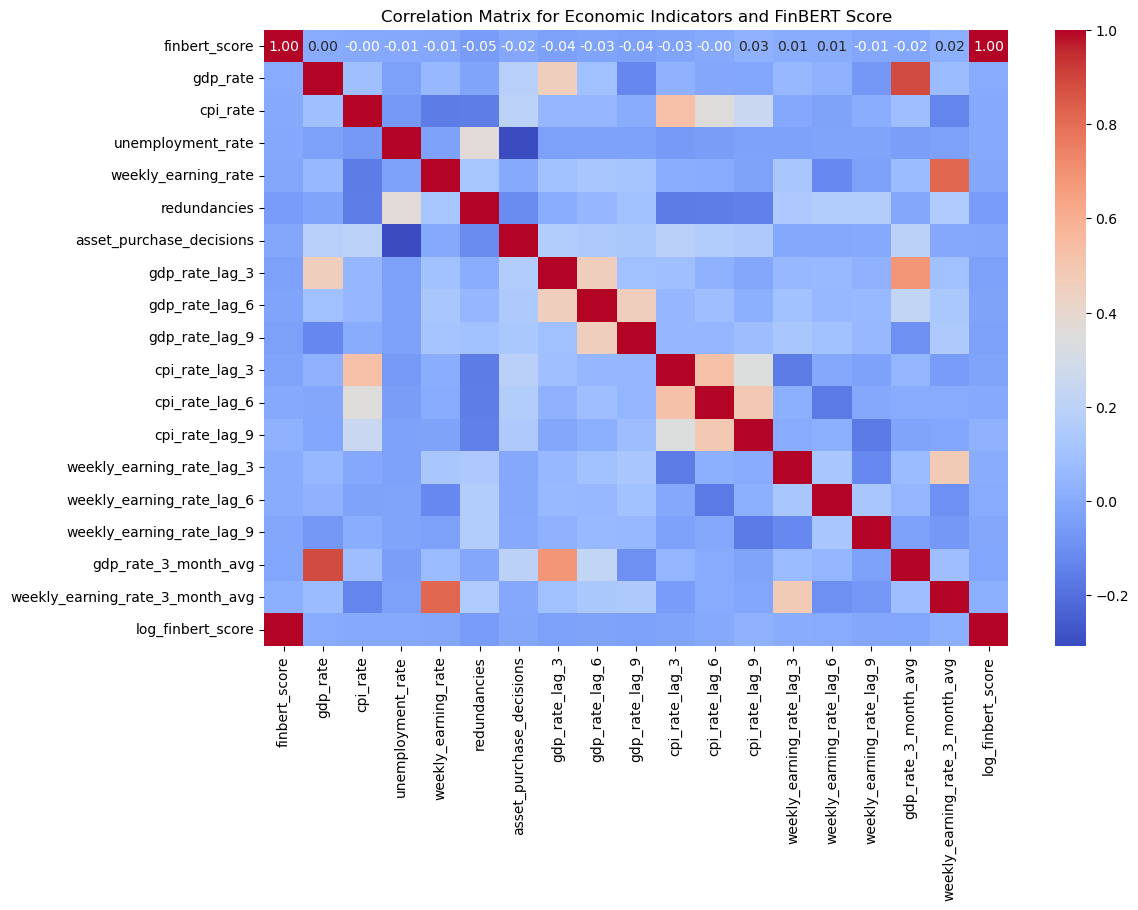

In [298]:
correlation_matrix = lagged_df[correlation_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for Economic Indicators and FinBERT Score")
plt.show()

- *Variance inflation factor for multicollinearity*

In [301]:
# Function for checking the Variance inflation factor.
def calculate_vif(df, x_cols):
    X = df[x_cols]
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Exclude variables subjected to high multicollinearity
x_columns = ['gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 'redundancies',
             'asset_purchase_decisions', 'gdp_rate_lag_3', 'gdp_rate_lag_6', 'gdp_rate_lag_9', 'cpi_rate_lag_3', 'cpi_rate_lag_6', 'cpi_rate_lag_9',
             'weekly_earning_rate_lag_3', 'weekly_earning_rate_lag_6', 'weekly_earning_rate_lag_9', 'gdp_rate_3_month_avg',
             'weekly_earning_rate_3_month_avg', 'log_finbert_score']

# Calculate VIF
print(f"Checking for Variance Inflation Factors for multicollinearity")
print(calculate_vif(lagged_df, x_columns))

Checking for Variance Inflation Factors for multicollinearity
                            Feature         VIF
0                             const  231.367739
1                          gdp_rate    5.858888
2                          cpi_rate    1.528579
3                 unemployment_rate    1.311589
4               weekly_earning_rate    4.209792
5                      redundancies    1.353759
6          asset_purchase_decisions    1.243401
7                    gdp_rate_lag_3    2.724732
8                    gdp_rate_lag_6    1.639406
9                    gdp_rate_lag_9    1.406371
10                   cpi_rate_lag_3    1.882575
11                   cpi_rate_lag_6    1.791383
12                   cpi_rate_lag_9    1.440033
13        weekly_earning_rate_lag_3    1.994754
14        weekly_earning_rate_lag_6    1.200063
15        weekly_earning_rate_lag_9    1.146849
16             gdp_rate_3_month_avg    8.778348
17  weekly_earning_rate_3_month_avg    5.377069
18                log_finb

- *Granger causality test*

In [304]:
# Granger Causality Test to assess whether a variable significantly predicts the dependent variable.
var_columns = ['finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate', 'weekly_earning_rate', 'redundancies', 
               'asset_purchase_decisions', 'log_finbert_score']

# Perform Granger causality tests for each pair of variables
max_lag = 3  # Use the same lag value as your VAR model
results = {}

for i in range(len(var_columns)):
    for j in range(len(var_columns)):
        if i != j:  # Skip testing the variable against itself
            # Test if var_columns[i] Granger-causes var_columns[j]
            test_result = grangercausalitytests(lagged_df[[var_columns[i], var_columns[j]]], max_lag, verbose=False)
            results[(var_columns[i], var_columns[j])] = test_result

# Display the results
for (cause, effect), test in results.items():
    print(f"Granger causality results: {cause} -> {effect}")
    for lag, result in test.items():
        f_statistic = result[0]['ssr_ftest'][0]
        p_value = result[0]['ssr_ftest'][1]
        print(f"Lag {lag}: F-statistic = {f_statistic:.3f}, p-value = {p_value:.3f}")
    print("\n" + "-" * 50 + "\n")


Granger causality results: finbert_score -> gdp_rate
Lag 1: F-statistic = 0.093, p-value = 0.761
Lag 2: F-statistic = 1.934, p-value = 0.145
Lag 3: F-statistic = 1.303, p-value = 0.272

--------------------------------------------------

Granger causality results: finbert_score -> cpi_rate
Lag 1: F-statistic = 1.197, p-value = 0.274
Lag 2: F-statistic = 1.632, p-value = 0.196
Lag 3: F-statistic = 1.555, p-value = 0.199

--------------------------------------------------

Granger causality results: finbert_score -> unemployment_rate
Lag 1: F-statistic = 0.019, p-value = 0.890
Lag 2: F-statistic = 0.017, p-value = 0.983
Lag 3: F-statistic = 0.047, p-value = 0.986

--------------------------------------------------

Granger causality results: finbert_score -> weekly_earning_rate
Lag 1: F-statistic = 0.730, p-value = 0.393
Lag 2: F-statistic = 0.880, p-value = 0.415
Lag 3: F-statistic = 0.949, p-value = 0.416

--------------------------------------------------

Granger causality results: f

Based on **Granger causality results**:
- Asset Purchase Decisions (lags 1-3, p < 0.05).
- Log FinBERT Score (lag 3, p = 0.034).
- Redundancies (lag 3, p = 0.043).
- GDP Rate, CPI Rate, Unemployment Rate, Weekly Earning Rate (all p > 0.1).

We'll keep considering GDP Rate, CPI Rate, Unemployment Rate as per their strong theoretical significance.

- *Augmented Dickey-Fuller (ADF) test for stationarity*

In [308]:
correlation_cols = ['finbert_score', 'gdp_rate', 'cpi_rate', 'unemployment_rate', 'asset_purchase_decisions', 'gdp_rate_lag_3',
                    'gdp_rate_lag_6', 'gdp_rate_lag_9', 'cpi_rate_lag_3', 'cpi_rate_lag_6', 'redundancies',
                    'cpi_rate_lag_9', 'gdp_rate_3_month_avg', 'weekly_earning_rate_3_month_avg', 'log_finbert_score']

# Augmented Dickey-Fuller (ADF) test for stationarity: variables with low p-values(<0.05) are stationary.
def adf_test(series):
    result = adfuller(series.dropna())
    return {'ADF Statistic': result[0], 'p-value': result[1]}

# Run ADF test on key variables
for col in correlation_cols:
    print(f'{col}:', adf_test(lagged_df[col]))

finbert_score: {'ADF Statistic': -31.443311090555188, 'p-value': 0.0}
gdp_rate: {'ADF Statistic': -9.932687610333158, 'p-value': 2.795740449077757e-17}
cpi_rate: {'ADF Statistic': -7.774456170175008, 'p-value': 8.74442550007097e-12}
unemployment_rate: {'ADF Statistic': -1.1210557754712855, 'p-value': 0.7066024854394346}
asset_purchase_decisions: {'ADF Statistic': -0.689275433216025, 'p-value': 0.8495079198723501}
gdp_rate_lag_3: {'ADF Statistic': -9.923479759525422, 'p-value': 2.948623472969941e-17}
gdp_rate_lag_6: {'ADF Statistic': -9.931669011628287, 'p-value': 2.8122529185461255e-17}
gdp_rate_lag_9: {'ADF Statistic': -9.936946341900857, 'p-value': 2.7277517668383183e-17}
cpi_rate_lag_3: {'ADF Statistic': -6.8087071948734295, 'p-value': 2.1435678002066318e-09}
cpi_rate_lag_6: {'ADF Statistic': -7.183005633353092, 'p-value': 2.6201064699714367e-10}
redundancies: {'ADF Statistic': -4.3096468035281505, 'p-value': 0.00042743243482586953}
cpi_rate_lag_9: {'ADF Statistic': -7.6879727791168

- **Stationary variables (p-value < 0.05)**: finbert_score, gdp_rate, gdp_rate_3_month_avg, cpi_rate, cpi_rate_3_month_avg, weekly_earning_rate, weekly_earning_rate_3_month_avg, gdp_rate_lag_3, cpi_rate_lag_3, weekly_earning_rate_lag_3. 

- **Non-stationary variables (p-value >= 0.05)**: unemployment_rate, unemployment_rate_3_month_avg, unemployment_rate_lag_3, asset_purchase_decisions.or SDifferenciate the non-stationary variablesy variables_lag_3


In [311]:
# Difference them to make them stationary.
lagged_df['unemployment_rate_diff'] = lagged_df['unemployment_rate'].diff().dropna()
lagged_df['asset_purchase_decisions_diff'] = lagged_df['asset_purchase_decisions'].diff().dropna()

### 

###  II. SARIMA Model Fit

In [315]:
lagged_df.set_index('date', inplace=True) 

# Clean the DataFrame
lagged_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
lagged_df.dropna(inplace=True)  # Drop rows with NaN in x_columns


In [317]:
# Fit Auto ARIMA to select the best model for finbert_score
auto_arima_model = pm.auto_arima(
    merged_df['finbert_score'],   # Series to model
    start_p=0, max_p=5,                 # Range of AR terms to try
    start_q=0, max_q=5,                 # Range of MA terms to try
    d=1,                                # Differencing order (based on your data)
    seasonal=True,                     # Set to True if data has a seasonal component
    stepwise=True,                      # Speeds up the search
    trace=True                          # Prints progress
)

# Show the summary of the best model found
print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1460.709, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1745.364, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1462.709, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1867.612, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1929.885, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-1955.203, Time=0.53 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-1992.710, Time=0.55 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-2146.395, Time=1.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-2114.574, Time=1.40 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=1.06 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0] intercept
Total fit time: 8.914 seconds
                               SA

In [319]:
# Define SARIMAX model function
def sarimax_model_forecast(
    data, 
    target_variable, 
    exogenous_variables, 
    order=(0, 1, 1), 
    seasonal_order=(1, 1, 1, 12), 
    train_ratio=0.8, 
    plot=True
):
    """
    Fits a SARIMA model on the given data with specified parameters, evaluates and forecasts.
    """

    # Define exogenous variables subset
    exog_vars = data[exogenous_variables]

    # Train-test split
    train_size = int(len(data) * train_ratio)
    train_data = data[target_variable][:train_size]
    test_data = data[target_variable][train_size:]
    train_exog = exog_vars[:train_size]
    test_exog = exog_vars[train_size:]

    # Build and fit SARIMAX model
    model = SARIMAX(
        endog=train_data,
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    sarimax_result = model.fit()

    # Forecast
    forecast = sarimax_result.forecast(steps=len(test_data), exog=test_exog)

    # Evaluation metrics
    mse = mean_squared_error(test_data, forecast)
    mae = mean_absolute_error(test_data, forecast)
    rmse = math.sqrt(mse)

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plotting
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(train_data, label='Training Data')
        plt.plot(test_data, label='Actual Data')
        plt.plot(test_data.index, forecast, label='SARIMAX Forecast', color='red')
        plt.title(f'SARIMAX Model with Seasonal Terms and Exogenous Variables')
        plt.xlabel('Time')
        plt.ylabel(target_variable)
        plt.legend()
        plt.show()

    # Model summary for diagnostics
    print(sarimax_result.summary())

    # Return results as a dictionary, now including test_data and train_size
    return {
        'sarimax_result': sarimax_result,
        'forecast': forecast,
        'test_data': test_data,  # Added test_data
        'train_size': train_size,  # Added train_size
        'mse': mse,
        'mae': mae,
        'rmse': rmse
    }


Mean Squared Error (MSE): 0.003256261688922541
Mean Absolute Error (MAE): 0.04249687774186747
Root Mean Squared Error (RMSE): 0.05706366347267358


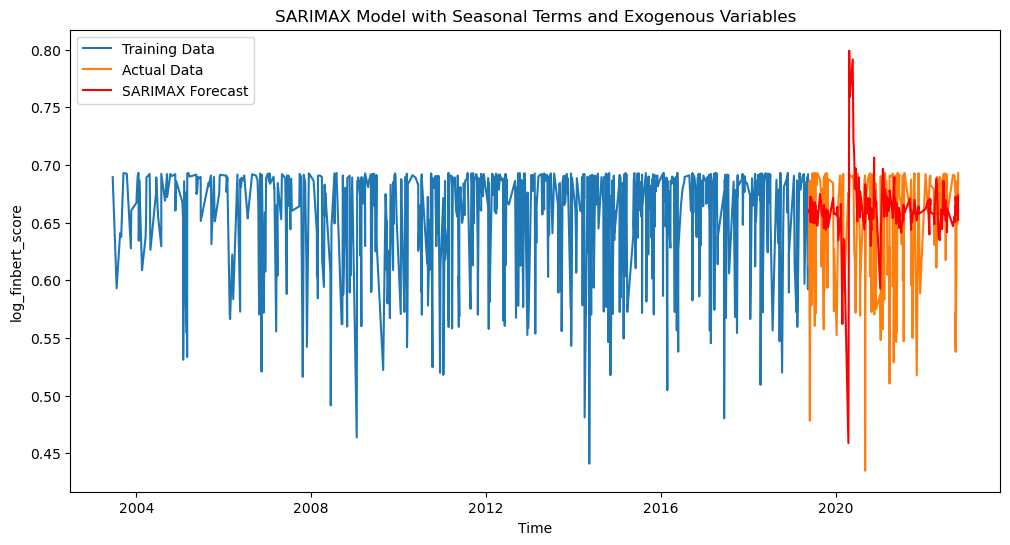

                                      SARIMAX Results                                       
Dep. Variable:                    log_finbert_score   No. Observations:                  838
Model:             SARIMAX(5, 1, 2)x(1, 1, [1], 12)   Log Likelihood                1316.952
Date:                              Mon, 18 Nov 2024   AIC                          -2599.905
Time:                                      13:41:56   BIC                          -2520.097
Sample:                                           0   HQIC                         -2569.261
                                              - 838                                         
Covariance Type:                                opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
gdp_rate                            1.6484      0.768   

In [321]:
# 1st attempt:
# Define Target and Exogenous variables
target_variable = 'log_finbert_score'

# 1st attempt:
# exogenous_variables = [ 'gdp_rate', 'weekly_earning_rate', 'cpi_rate','gdp_rate_lag_3', 'cpi_rate_lag_3',
#                       'weekly_earning_rate_lag_6', 'unemployment_rate_diff', 'asset_purchase_decisions_diff', 
#                       'gdp_rate_3_month_avg', 'weekly_earning_rate_3_month_avg']

# 2nd attempt:
exogenous_variables = [ 'gdp_rate', 'gdp_rate_lag_3', 'gdp_rate_3_month_avg', 'cpi_rate', 'cpi_rate_lag_3', 
                       'weekly_earning_rate_lag_6', 'weekly_earning_rate_3_month_avg']


# Call the sarimax_model_forecast function
result_2 = sarimax_model_forecast(
    data=lagged_df, 
    target_variable=target_variable,
    exogenous_variables=exogenous_variables,
    order=(5, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    train_ratio=0.8
)


- gdp_rate and gdp_rate_3_month_avg: Use one as a representative of GDP trends, prioritizing if GDP shifts align with speech impacts. 
- cpi_rate and cpi_rate_lag_3: CPI often reflects inflation response; try both to see if lagged vs. current rate offers stronger predictive power. 
- weekly_earning_rate_3_month_avg: Earnings could indicate economic confidence, so testing the 3-month average may highlight sustained effects.

Mean Squared Error (MSE): 0.010014445983366756
Mean Absolute Error (MAE): 0.07666868307598483
Root Mean Squared Error (RMSE): 0.10007220384985412


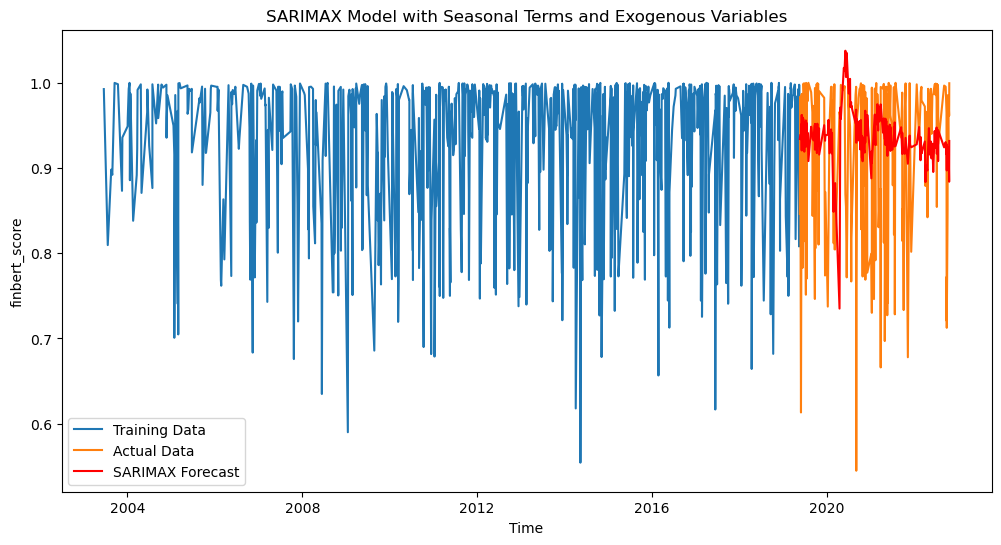

                                      SARIMAX Results                                       
Dep. Variable:                        finbert_score   No. Observations:                  838
Model:             SARIMAX(5, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 820.753
Date:                              Mon, 18 Nov 2024   AIC                          -1613.507
Time:                                      13:42:09   BIC                          -1547.783
Sample:                                           0   HQIC                         -1588.270
                                              - 838                                         
Covariance Type:                                opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
gdp_rate                            0.9226      0.623   

In [323]:
# 3rd attempt
# Define Target and Exogenous variables
target_variable = 'finbert_score'
exogenous_variables = ['gdp_rate','cpi_rate', 'cpi_rate_3_month_avg', 'weekly_earning_rate_3_month_avg']

# Call the sarimax_model_forecast function
result_3 = sarimax_model_forecast(
    data=lagged_df, 
    target_variable=target_variable,
    exogenous_variables=exogenous_variables,
    order=(5, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    train_ratio=0.8
)


This updated SARIMA model has further reduced prediction errors, achieving a slightly improved fit by incorporating key exogenous variables, particularly those related to CPI, for predicting the finbert_score.

**Key Findings from the Coefficients** 
- gdp_rate: Statistically significant with a p-value of 0.001, indicating that the GDP rate plays a crucial role in predicting finbert_score.
- cpi_rate_3_month_avg: it shows a negative coefficient, suggesting a negative relationship with the sentiment measure.
- cpi_rate and weekly_earning_rate_3_month_avg: These variables are not significant (p-values > 0.05), which suggests that short-term changes in CPI and in weekly earnings have a lesser impact on finbert_score.

**Interpretation of Model Coefficients** \
The results suggest that while the GDP rate is highly influential, the CPI-related features, having a negative coefficient suggests a negative relationship with the sentiment measure, meaning that higher CPI over the past three months is associated with a decrease in sentiment.

###

### III. Residual diagnostics and Statistical test 

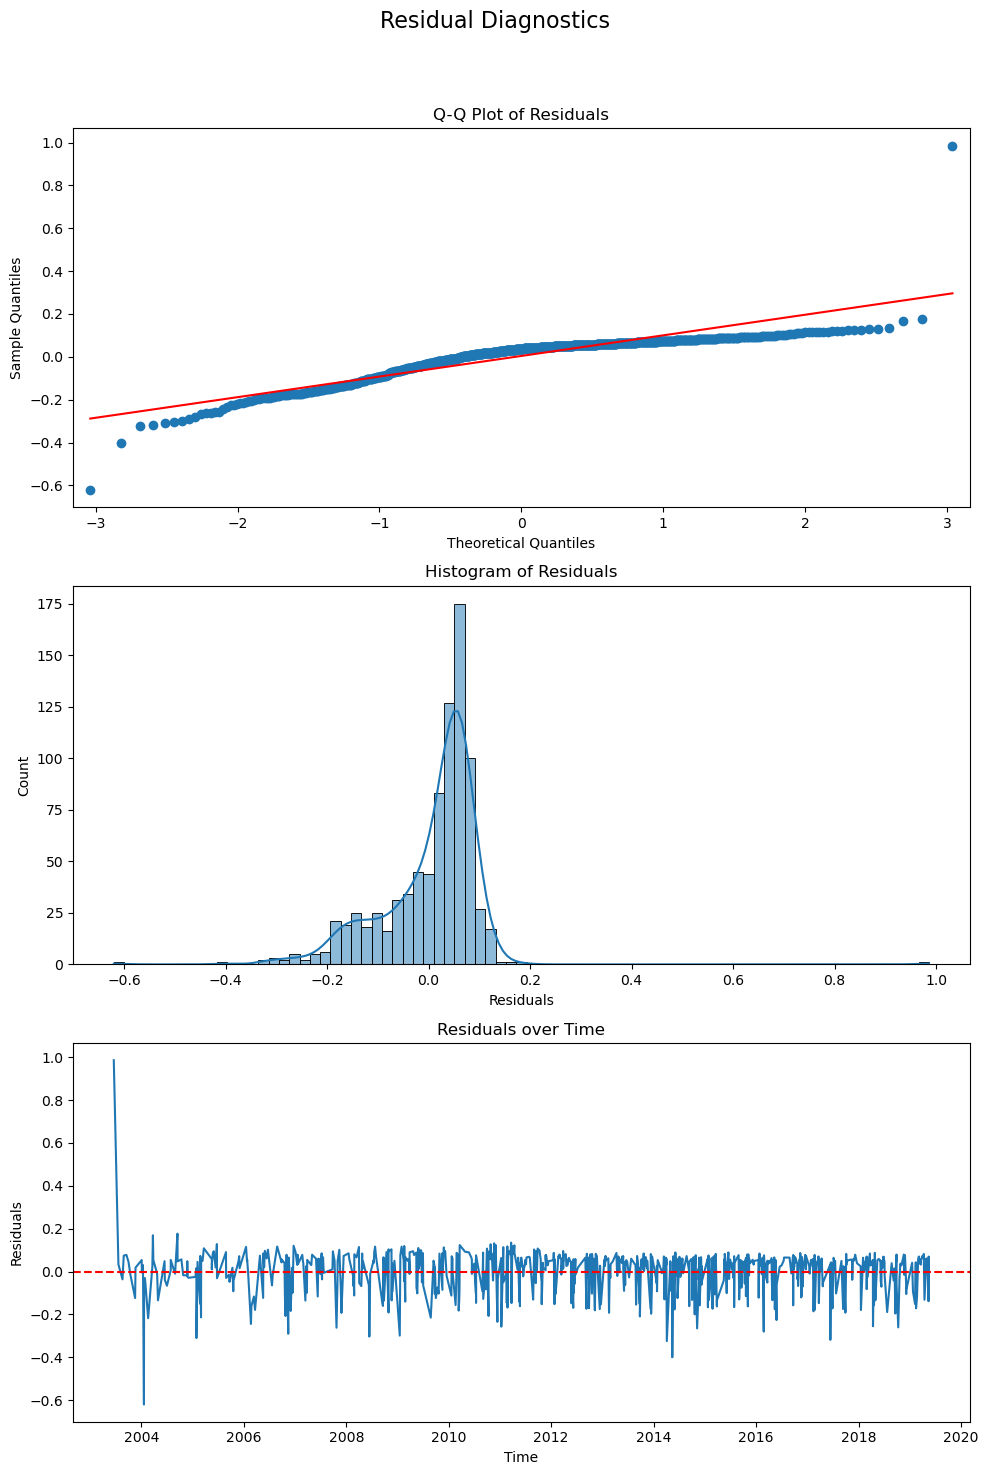

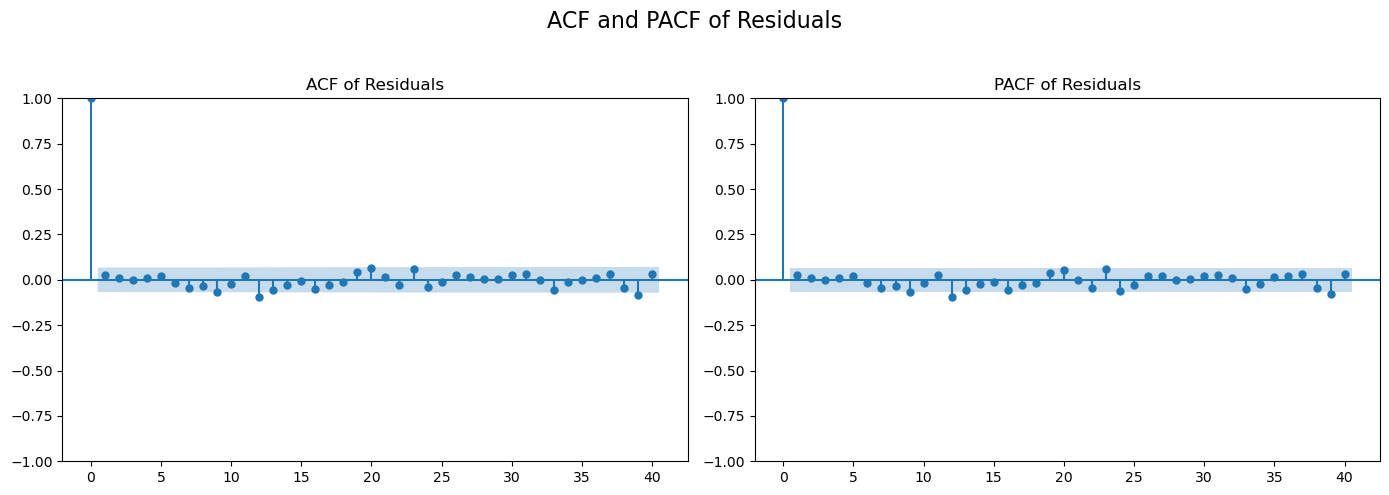

In [325]:
# Function to plot residual diagnostics
def plot_residual_diagnostics(fitted_model):
    """
    Generates residual diagnostics plots for a fitted SARIMAX model.
    Returns residuals for further analysis.
    """
    # Extract residuals
    residuals = fitted_model.resid

    # Set up the figure for the first section (Q-Q plot, histogram, and residuals over time)
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    fig.suptitle("Residual Diagnostics", fontsize=16)

    # Q-Q plot for residuals
    sm.qqplot(residuals, line='s', ax=axes[0])
    axes[0].set_title("Q-Q Plot of Residuals")

    # Histogram of residuals
    sns.histplot(residuals, kde=True, ax=axes[1])
    axes[1].set_title("Histogram of Residuals")
    axes[1].set_xlabel("Residuals")

    # Residuals over time
    axes[2].plot(residuals)
    axes[2].set_title("Residuals over Time")
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("Residuals")
    axes[2].axhline(0, color='red', linestyle='--')  # Add red line at y=0

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Second section: ACF and PACF of residuals
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle("ACF and PACF of Residuals", fontsize=16)

    # ACF plot
    plot_acf(residuals, ax=axes[0], lags=40)
    axes[0].set_title("ACF of Residuals")

    # PACF plot
    plot_pacf(residuals, ax=axes[1], lags=40, method='ywm')
    axes[1].set_title("PACF of Residuals")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return residuals

# Call the function
residuals = plot_residual_diagnostics(result_3['sarimax_result'])


In [327]:
# Function for statistical test
def perform_statistical_tests(residuals):
    """
    Performs Ljung-Box and Jarque-Bera tests on residuals and prints results.
    """
    # Ljung-Box test for autocorrelation
    ljung_box_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    ljung_box_p_value = ljung_box_test['lb_pvalue'].iloc[0]

    # Jarque-Bera test for normality
    jarque_bera_test = sm.stats.jarque_bera(residuals)
    jb_stat, jb_p_value, skewness, kurtosis = jarque_bera_test

    # Interpret results
    if ljung_box_p_value > 0.05:
        print("Ljung-Box Test: No significant autocorrelation, indicating a good fit.")
    else:
        print("Ljung-Box Test: Significant autocorrelation detected, model may need improvement.")

    if jb_p_value > 0.05:
        print("Jarque-Bera Test: Residuals appear to be normally distributed.")
    else:
        print("Jarque-Bera Test: Some skewness and kurtosis remain, indicating slight deviations from normality.")

    # Print detailed results for reference
    print(f"Ljung-Box p-value: {ljung_box_p_value}")
    print(f"Jarque-Bera p-value: {jb_p_value}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")

# Run the tests
perform_statistical_tests(residuals)


Ljung-Box Test: No significant autocorrelation, indicating a good fit.
Jarque-Bera Test: Some skewness and kurtosis remain, indicating slight deviations from normality.
Ljung-Box p-value: 0.5949647117876239
Jarque-Bera p-value: 0.0
Skewness: -0.06939004185701264
Kurtosis: 18.14065483388409


**Notes on residual diagnostics**: the Ljung-Box test indicates no significant autocorrelation in the residuals, supporting the model’s adequacy in capturing time series dependencies. However, the Jarque-Bera test reveals non-normality in the residuals, especially due to negative skewness and excess kurtosis. It may not severely undermine the model's performance: overall, the model captures the main temporal patterns well, but there are slight issues with the distribution of residuals that may warrant further investigation or adjustments.

###

### IV. Forecast and Visualisations

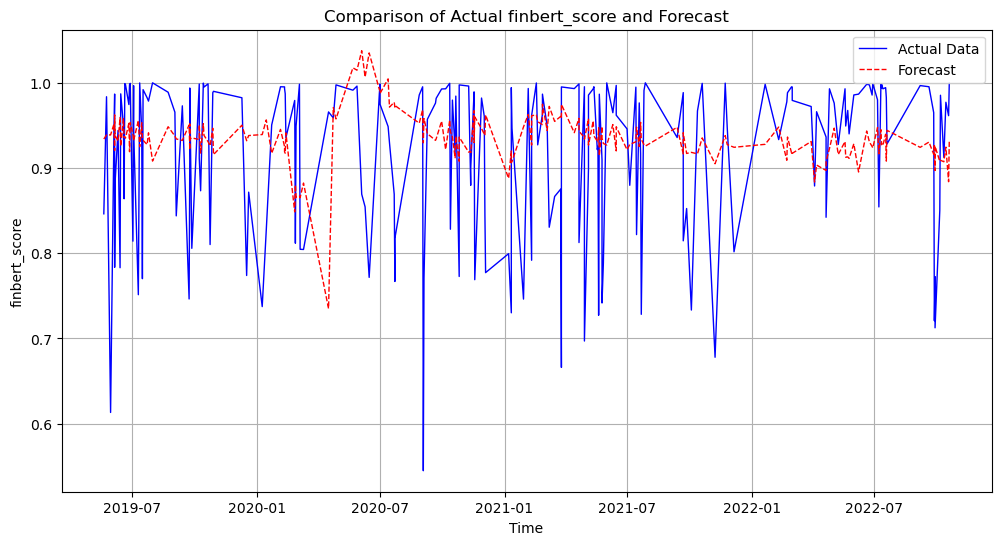

In [331]:
# Define a function for plotting actual and forecasted values
def plot_actual_and_forecast(test_data, forecast, target_variable):
    """
    Plots actual test data and SARIMAX forecasted values for comparison.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot Actual Test Data
    plt.plot(test_data.index, test_data, label='Actual Data', color='blue', linestyle='-', linewidth=1)
    
    # Plot Forecasted Data
    if isinstance(forecast, pd.Series):
        plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--', linewidth=1)
    elif isinstance(forecast, pd.DataFrame):
        for column in forecast.columns:
            plt.plot(forecast.index, forecast[column], label=f'Forecast {column}', linestyle='--', linewidth=1)
    else:
        raise ValueError("Forecast data must be a pandas Series or DataFrame.")

    # Add titles and labels
    plt.title(f'Comparison of Actual {target_variable} and Forecast')
    plt.xlabel('Time')
    plt.ylabel(target_variable)
    plt.legend()
    plt.grid(True)
    plt.show()


# Extract test_data and forecast from the results
test_data = result_3['test_data']
forecast = result_3['forecast']

forecast.index = test_data.index

# Plot the actual vs. forecast data
plot_actual_and_forecast(test_data=test_data, forecast=forecast, target_variable=target_variable)


In [333]:
# Define the number of forecast steps
forecast_steps = 75

# Prepare the exogenous data for the forecast period
# Make sure exog_forecast has the correct shape (12 rows of exogenous data for 12 forecast steps)
exog_forecast = lagged_df[exogenous_variables].iloc[-forecast_steps:]

# Use the SARIMAX model result stored in result_3 to generate the forecast
forecast_object = result_3['sarimax_result'].get_forecast(steps=forecast_steps, exog=exog_forecast)
forecast_values = forecast_object.predicted_mean

# Confidence intervals for the forecast
confidence_intervals = forecast_object.conf_int()

# Print forecast values and confidence intervals
print("Forecast values:\n", forecast_values)
print("\nConfidence intervals:\n", confidence_intervals)


Forecast values:
 838    0.928260
839    0.930464
840    0.930439
841    0.943211
842    0.912244
         ...   
908    0.896240
909    0.924542
910    0.906942
911    0.900776
912    0.912367
Name: predicted_mean, Length: 75, dtype: float64

Confidence intervals:
      lower finbert_score  upper finbert_score
838             0.761178             1.095342
839             0.763374             1.097555
840             0.763350             1.097529
841             0.776078             1.110345
842             0.745073             1.079416
..                   ...                  ...
908             0.728898             1.063582
909             0.757200             1.091885
910             0.739563             1.074321
911             0.733396             1.068156
912             0.744987             1.079747

[75 rows x 2 columns]


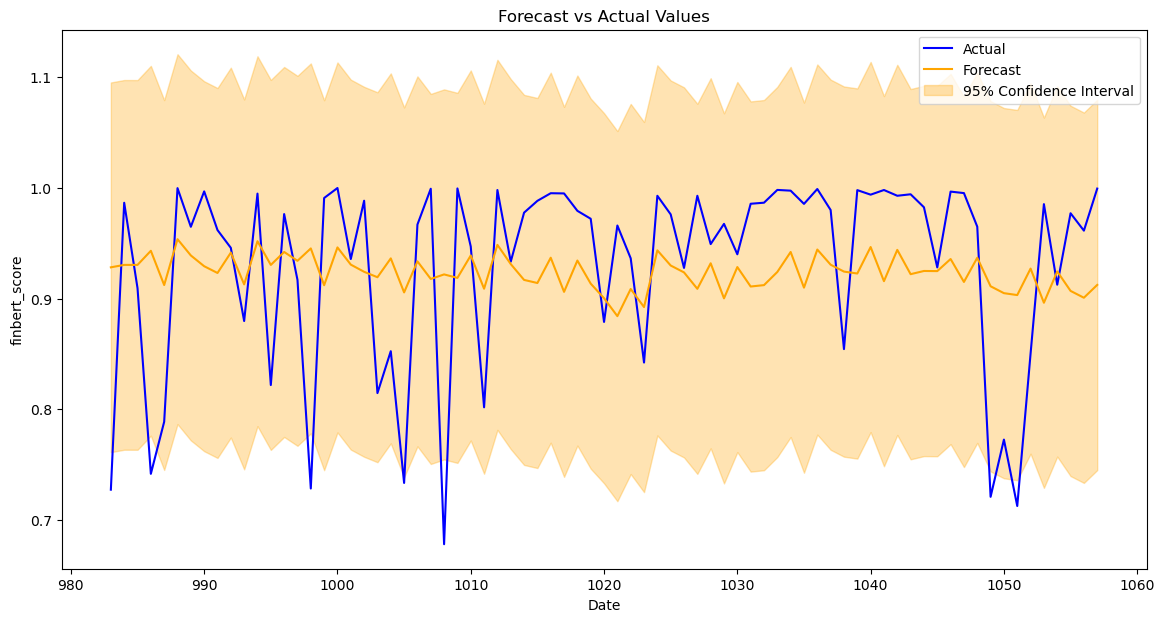

In [335]:
# Plot actual vs. forecasted values
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index[-len(forecast_values):], merged_df[target_variable].iloc[-len(forecast_values):], label='Actual', color='blue')
plt.plot(merged_df.index[-len(forecast_values):], forecast_values, label='Forecast', color='orange')
plt.fill_between(
    merged_df.index[-len(forecast_values):],
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title('Forecast vs Actual Values')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.legend()
plt.show()


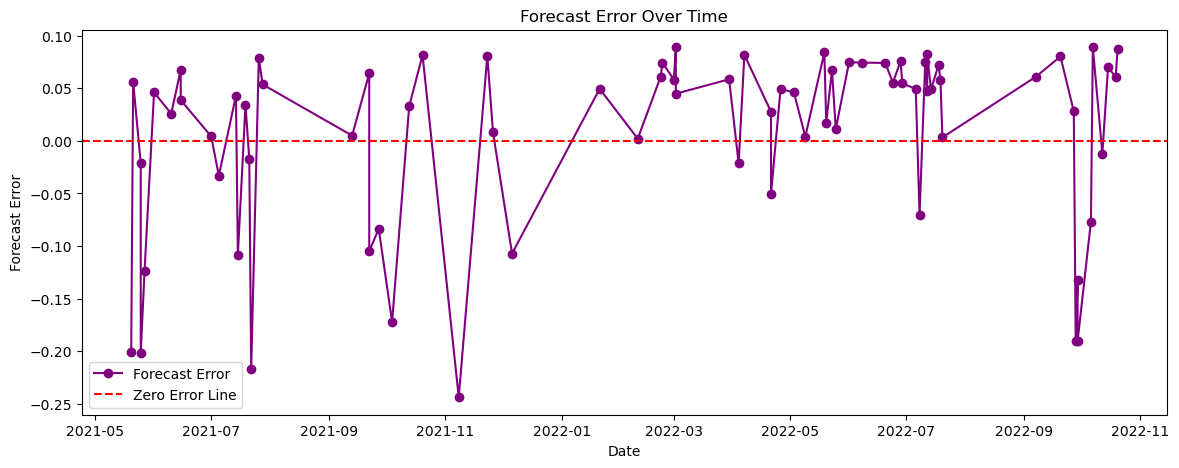

In [337]:
# Ensure `forecast_values` length matches `actual_values` length
forecast_length = len(forecast_values)
actual_values = lagged_df[target_variable].iloc[-forecast_length:]  # Match length with forecast

# Calculate forecast error
forecast_error = actual_values.values - forecast_values.values  # Ensure matching shapes

# Plot forecast error
plt.figure(figsize=(14, 5))
plt.plot(actual_values.index, forecast_error, color='purple', marker='o', label='Forecast Error')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.title('Forecast Error Over Time')
plt.xlabel('Date')
plt.ylabel('Forecast Error')
plt.legend()
plt.show()


**[Table of Contents](#Table_of_contents)**